In [1]:
import torch
import sys
import pyro

import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import pandas as pd

import numpy as np

from pooledQTL import deconvolve, beta_model, gaussian_model, io_utils, asb_data

from importlib import reload

from pathlib import Path

fdr_threshold = 0.05
device = "cuda:0" if torch.cuda.is_available() else "cpu"
use_structured_guide = True # performs much better

In [2]:
from pathlib import Path

 Load input RNA allelic counts.

In [3]:
rbps = ["24a-hNIL-control-tdp", "24a-hNIL-c9-tdp", "24a-hNIP-control-tdp", "24a-hNIP-c9-tdp"]
donors = [
    "CTRL-NEUHE723FGT-02545-G", "CASE-NEUFV237VCZ-01369-G",   
    "CTRL-NEUHE723FGT-02545-G", "CASE-NEUFV237VCZ-01369-G"]   
vcf = "/gpfs/commons/groups/knowles_lab/bindingQTL_share/genotype/chrAll_QCFinished_full_2sample.anno.vcf"
#vcf = "/gpfs/commons/groups/knowles_lab/bindingQTL_share/genotype/chrAll_QCFinished_full.anno.vcf"
basedir = Path("/gpfs/commons/home/dmeyer/bindingQTL_share")

In [4]:
input_files = [basedir / rbp / f"allelic/{rbp}_input_allelic.out" for rbp in rbps]
#input_files_filtered = [basedir / rbp / f"allelic/{rbp}_input_allelic.filtered_epsilon0.3.txt" for rbp in rbps]
input_files_filtered = [basedir / rbp / f"allelic/{rbp}_input_allelic.10readsInput_filtered_epsilon0.3_sharedhet.txt" for rbp in rbps]
IP_files = [basedir / rbp / f"allelic/{rbp}_ip_allelic.out" for rbp in rbps]
input_counts = [ pd.read_csv(f, sep = "\t", usecols = range(8), index_col = False) for f in input_files]
input_counts_filtered = [ pd.read_csv(f, sep = "\t", usecols = range(8), index_col = False) for f in input_files_filtered]
IP_counts = [ pd.read_csv(f, sep = "\t", usecols = range(8), index_col = False) for f in IP_files]

In [9]:
for x,y in zip(input_files_filtered, IP_files):
    print(str(x), str(y))

/gpfs/commons/home/dmeyer/bindingQTL_share/24a-hNIL-control-tdp/allelic/24a-hNIL-control-tdp_input_allelic.filtered_epsilon0.3_sharedhet.txt /gpfs/commons/home/dmeyer/bindingQTL_share/24a-hNIL-control-tdp/allelic/24a-hNIL-control-tdp_ip_allelic.out
/gpfs/commons/home/dmeyer/bindingQTL_share/24a-hNIL-c9-tdp/allelic/24a-hNIL-c9-tdp_input_allelic.filtered_epsilon0.3_sharedhet.txt /gpfs/commons/home/dmeyer/bindingQTL_share/24a-hNIL-c9-tdp/allelic/24a-hNIL-c9-tdp_ip_allelic.out
/gpfs/commons/home/dmeyer/bindingQTL_share/24a-hNIP-control-tdp/allelic/24a-hNIP-control-tdp_input_allelic.filtered_epsilon0.3_sharedhet.txt /gpfs/commons/home/dmeyer/bindingQTL_share/24a-hNIP-control-tdp/allelic/24a-hNIP-control-tdp_ip_allelic.out
/gpfs/commons/home/dmeyer/bindingQTL_share/24a-hNIP-c9-tdp/allelic/24a-hNIP-c9-tdp_input_allelic.filtered_epsilon0.3_sharedhet.txt /gpfs/commons/home/dmeyer/bindingQTL_share/24a-hNIP-c9-tdp/allelic/24a-hNIP-c9-tdp_ip_allelic.out


Observed genotype data (after running StrandScript)

In [90]:
for i in range(len(rbps)):
    results_dir = PosixPath(f'/gpfs/commons/home/dmeyer/bindingQTL_share/{rbps[i]}/allelic')
    print(str(results_dir / (f"{rbps[i]}_beta_filtered_epsilon0.3_ipreads30_struct_with_peaks.tsv.gz")))

/gpfs/commons/home/dmeyer/bindingQTL_share/24a-hNIL-control-tdp/allelic/24a-hNIL-control-tdp_beta_filtered_epsilon0.3_ipreads30_struct_with_peaks.tsv.gz
/gpfs/commons/home/dmeyer/bindingQTL_share/24a-hNIL-c9-tdp/allelic/24a-hNIL-c9-tdp_beta_filtered_epsilon0.3_ipreads30_struct_with_peaks.tsv.gz
/gpfs/commons/home/dmeyer/bindingQTL_share/24a-hNIP-control-tdp/allelic/24a-hNIP-control-tdp_beta_filtered_epsilon0.3_ipreads30_struct_with_peaks.tsv.gz
/gpfs/commons/home/dmeyer/bindingQTL_share/24a-hNIP-c9-tdp/allelic/24a-hNIP-c9-tdp_beta_filtered_epsilon0.3_ipreads30_struct_with_peaks.tsv.gz


In [89]:
for x in input_files_filtered:
    print(str(x))

/gpfs/commons/home/dmeyer/bindingQTL_share/24a-hNIL-control-tdp/allelic/24a-hNIL-control-tdp_input_allelic.filtered_epsilon0.3.txt
/gpfs/commons/home/dmeyer/bindingQTL_share/24a-hNIL-c9-tdp/allelic/24a-hNIL-c9-tdp_input_allelic.filtered_epsilon0.3.txt
/gpfs/commons/home/dmeyer/bindingQTL_share/24a-hNIP-control-tdp/allelic/24a-hNIP-control-tdp_input_allelic.filtered_epsilon0.3.txt
/gpfs/commons/home/dmeyer/bindingQTL_share/24a-hNIP-c9-tdp/allelic/24a-hNIP-c9-tdp_input_allelic.filtered_epsilon0.3.txt


In [91]:
peaks_file_neg

'/gpfs/commons/home/dmeyer/bindingQTL_share/24a-hNIP-c9-tdp/peaks/24a-hNIP-c9-tdp-neg_peaks.narrowPeak'

In [ ]:
/gpfs/commons/home/dmeyer/bindingQTL_share/24a-hNIL-control-tdp/allelic/24a-hNIL-control-tdp_beta_filtered_epsilon0.3_ipreads30_struct_with_peaks.tsv.gz
/gpfs/commons/home/dmeyer/bindingQTL_share/24a-hNIL-c9-tdp/allelic/24a-hNIL-c9-tdp_beta_filtered_epsilon0.3_ipreads30_struct_with_peaks.tsv.gz
/gpfs/commons/home/dmeyer/bindingQTL_share/24a-hNIP-control-tdp/allelic/24a-hNIP-control-tdp_beta_filtered_epsilon0.3_ipreads30_struct_with_peaks.tsv.gz
/gpfs/commons/home/dmeyer/bindingQTL_share/24a-hNIP-c9-tdp/allelic/24a-hNIP-c9-tdp_beta_filtered_epsilon0.3_ipreads30_struct_with_peaks.tsv.gz
/gpfs/commons/home/dmeyer/bindingQTL_share/24a-hNIL-control-tdp/allelic/24a-hNIL-control-tdp_input_allelic.out
/gpfs/commons/home/dmeyer/bindingQTL_share/24a-hNIL-c9-tdp/allelic/24a-hNIL-c9-tdp_input_allelic.out
/gpfs/commons/home/dmeyer/bindingQTL_share/24a-hNIP-control-tdp/allelic/24a-hNIP-control-tdp_input_allelic.out
/gpfs/commons/home/dmeyer/bindingQTL_share/24a-hNIP-c9-tdp/allelic/24a-hNIP-c9-tdp_input_allelic.out
/gpfs/commons/home/dmeyer/bindingQTL_share/24a-hNIL-control-tdp/allelic/24a-hNIL-control-tdp_ip_allelic.out
/gpfs/commons/home/dmeyer/bindingQTL_share/24a-hNIL-c9-tdp/allelic/24a-hNIL-c9-tdp_ip_allelic.out
/gpfs/commons/home/dmeyer/bindingQTL_share/24a-hNIP-control-tdp/allelic/24a-hNIP-control-tdp_ip_allelic.out
/gpfs/commons/home/dmeyer/bindingQTL_share/24a-hNIP-c9-tdp/allelic/24a-hNIP-c9-tdp_ip_allelic.out
/gpfs/commons/home/dmeyer/bindingQTL_share/24a-hNIL-control-tdp/allelic/24a-hNIL-control-tdp_input_allelic.filtered_epsilon0.3.txt
/gpfs/commons/home/dmeyer/bindingQTL_share/24a-hNIL-c9-tdp/allelic/24a-hNIL-c9-tdp_input_allelic.filtered_epsilon0.3.txt
/gpfs/commons/home/dmeyer/bindingQTL_share/24a-hNIP-control-tdp/allelic/24a-hNIP-control-tdp_input_allelic.filtered_epsilon0.3.txt
/gpfs/commons/home/dmeyer/bindingQTL_share/24a-hNIP-c9-tdp/allelic/24a-hNIP-c9-tdp_input_allelic.filtered_epsilon0.3.txt

In [ ]:
for i in /gpfs/commons/home/dmeyer/bindingQTL_share/24a-hNIL-control-tdp/allelic/24a-hNIL-control-tdp_input_allelic.out /gpfs/commons/home/dmeyer/bindingQTL_share/24a-hNIL-c9-tdp/allelic/24a-hNIL-c9-tdp_input_allelic.out /gpfs/commons/home/dmeyer/bindingQTL_share/24a-hNIP-control-tdp/allelic/24a-hNIP-control-tdp_input_allelic.out /gpfs/commons/home/dmeyer/bindingQTL_share/24a-hNIP-c9-tdp/allelic/24a-hNIP-c9-tdp_input_allelic.out; do wc -l $i; done

## Load imputed genotypes

In [ ]:
#sanger = io_utils.loadGenotypes(
#    vcf,
#    maxlines = None, 
#    posterior = False,
#    print_every = 1e5,
#    add_chr_prefix="").rename(columns = {"SNP" : "variantID"})
#sanger.reset_index().to_feather(vcf + ".feather")

In [9]:
#sanger_feather = Path(vcf+".feather")
#sanger = pd.read_feather(sanger_feather).rename(columns = {"SNP" : "variantID"})
#del sanger["index"]
#sanger = sanger[sanger.variantID != "."]
#sanger = sanger[~sanger.variantID.duplicated()] # this removes triallelic SNPs, which I don't think we know how to handle anyway
#cols = list(sanger.columns)
#cols[0], cols[1] = cols[1], cols[0]
#sanger = sanger.loc[:,cols]
#sanger.reset_index().to_feather(vcf + ".feather")

In [6]:
sanger_feather = Path(vcf+".feather")
sanger = pd.read_feather(sanger_feather)
del sanger["index"]

In [6]:
sanger

contig  position     variantID refAllele altAllele  \
0          chr1    770471  rs1033598197         T         C   
1          chr1    778597    rs74512038         C         T   
2          chr1    778602   rs377318662         T         C   
3          chr1    778622   rs143219077         C         G   
4          chr1    778809   rs186983562         A         G   
...         ...       ...           ...       ...       ...   
36888227  chr22  50775215   rs144450696         C         G   
36888228  chr22  50775255   rs185532268         C         T   
36888229  chr22  50776939  rs1276126083         G         A   
36888230  chr22  50780366   rs147736082         G         A   
36888231  chr22  50780462   rs532086713         G         A   

          CTRL-NEUHE723FGT-02545-G  CASE-NEUFV237VCZ-01369-G  
0                              0.0                       0.0  
1                              0.0                       0.0  
2                              0.0                       0.0  
3                              0.0                       0.0  
4                              0.0                       0.0  
...                            ...                       ...  
36888227                       0.0                       0.0  
36888228                       0.0                       0.0  
36888229                       0.0                       0.0  
36888230                       0.0                       0.0  
36888231                       0.0                       0.0  

[36888232 rows x 7 columns]

## Look at phase within genes

In [8]:
sample_ind = [ g for g in cols if "CW" in g ][0]
sample_ind = [ g for g in cols if "CW70142" in g ][0]

In [ ]:
import pickle
with open("/home/dmeyer/projects/bqtls/sanger.v.pickle", "rb") as f:
    v = pickle.load(f)


In [11]:
import vcf
import gzip
vcf_reader = vcf.Reader(filename = vcf)

gen = [next(vcf_reader) for _ in range(10000)]
gen = vcf_reader

#v = [ (record.CHROM, 
# record.POS, 
# record.ID, 
# record.REF, 
# record.ALT[0].sequence, 
# record.genotype(sample_ind).data.GT, 
# record.genotype(sample_ind).data.ADS[0],
# record.genotype(sample_ind).data.ADS[1]) 
#      for record in gen if (record.genotype(sample_ind).data.GT != "0|0") ]

chroms, pos, ids, ref, alt, gt, ads1, ads2 = zip(*v)
#phased = pd.DataFrame({
#    "contig" : chroms,
#    "position" : pos,
#    "SNP" : ids, 
#    "refAllele" : ref, 
#    "altAllele" : alt, 
#    "GT" : gt, 
#    "dosage1" : ads1, # dosage for haplotype 1
#    "dosage2" : ads2 # dosage for haplotype 2
#})
#
#phased.to_csv(
#    '/home/dmeyer/projects/bqtls/CW70142.phased.csv', 
#    index = False, 
#    sep = "\t")

In [103]:
#import pickle
#with open("/home/dmeyer/projects/bqtls/sanger.v.pickle", "wb") as f:
#    pickle.dump(v, f)

In [12]:
phased = pd.read_table('/home/dmeyer/projects/bqtls/CW70142.phased.csv', sep="\t", index_col=None)

In [13]:
phased.SNP = phased.SNP.astype('str')
phased.contig = phased.contig.astype('str')
phased.contig = "chr" + phased.contig
phased_clean = phased[phased.SNP != "None"]

In [14]:
dat = input_counts[0]
dat = dat.rename(columns={ "chrom":"contig" })
dat_IP = IP_counts[0]

dat = dat[dat.variantID != "."]
dat = dat[~dat.variantID.duplicated()]
dat_IP = dat_IP[dat_IP.variantID != "."]
dat_IP = dat_IP[~dat_IP.variantID.duplicated()]

imp_merged = phased_clean.rename(
    columns = {"SNP" : "variantID"}
).merge(
    dat, 
    on = ["contig", "variantID", "refAllele", "altAllele"],
    suffixes = ["_hg19",""]) # sanger is hg19
imp_merged["input_ratio"] = imp_merged.altCount / imp_merged.totalCount


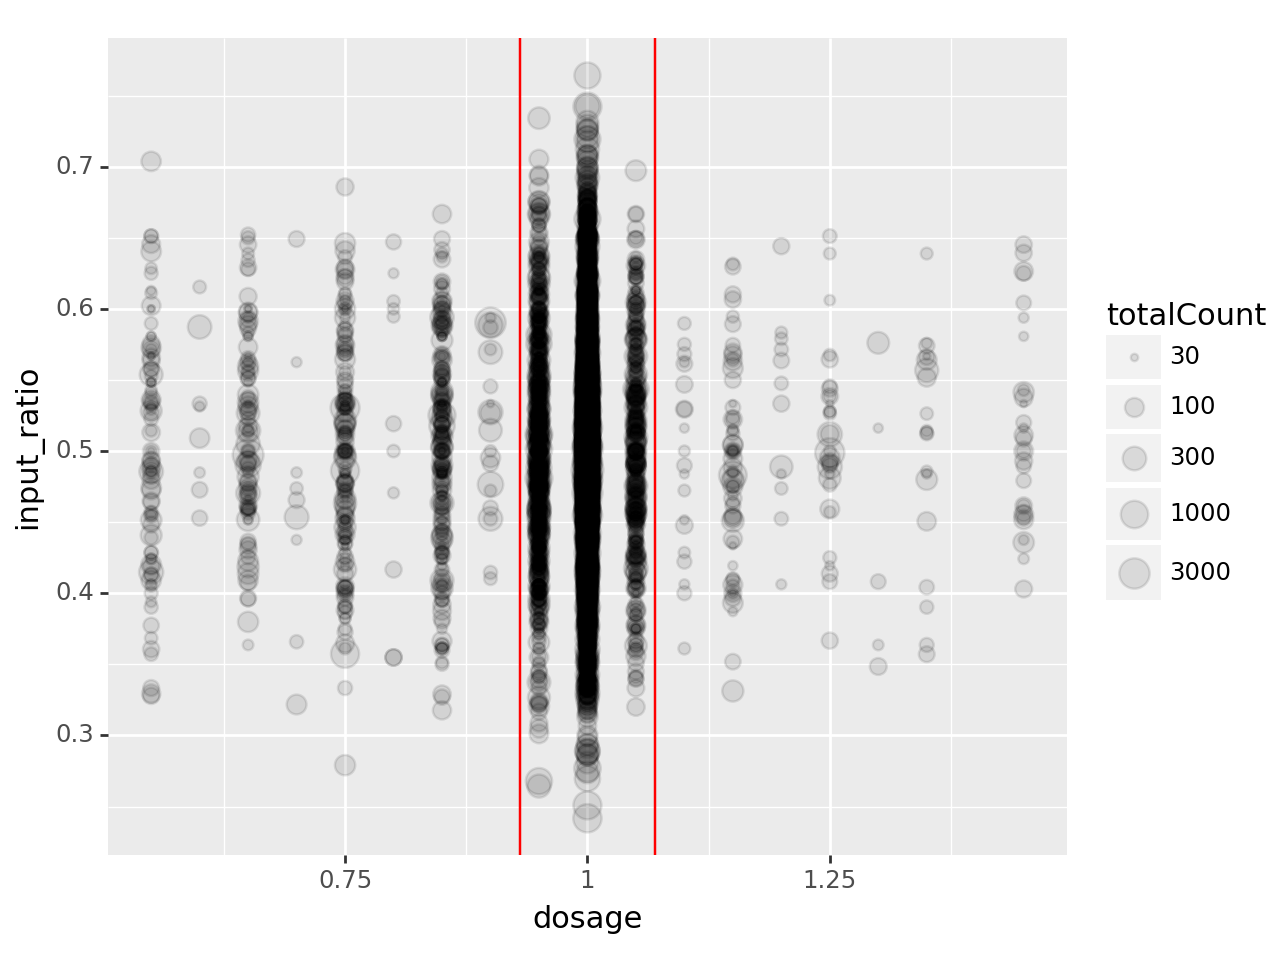

<Figure Size: (640 x 480)>

In [16]:
imp_merged["dosage"] = imp_merged.dosage1 + imp_merged.dosage2

import plotnine as p9
( p9.ggplot(imp_merged[imp_merged.totalCount >= 30], p9.aes("dosage", "input_ratio", size = "totalCount")) + 
 p9.geom_point(alpha = 0.1) + 
 p9.scale_size(trans = "log10") + 
 p9.geom_vline(xintercept = [.93,1.07], color = "red") )

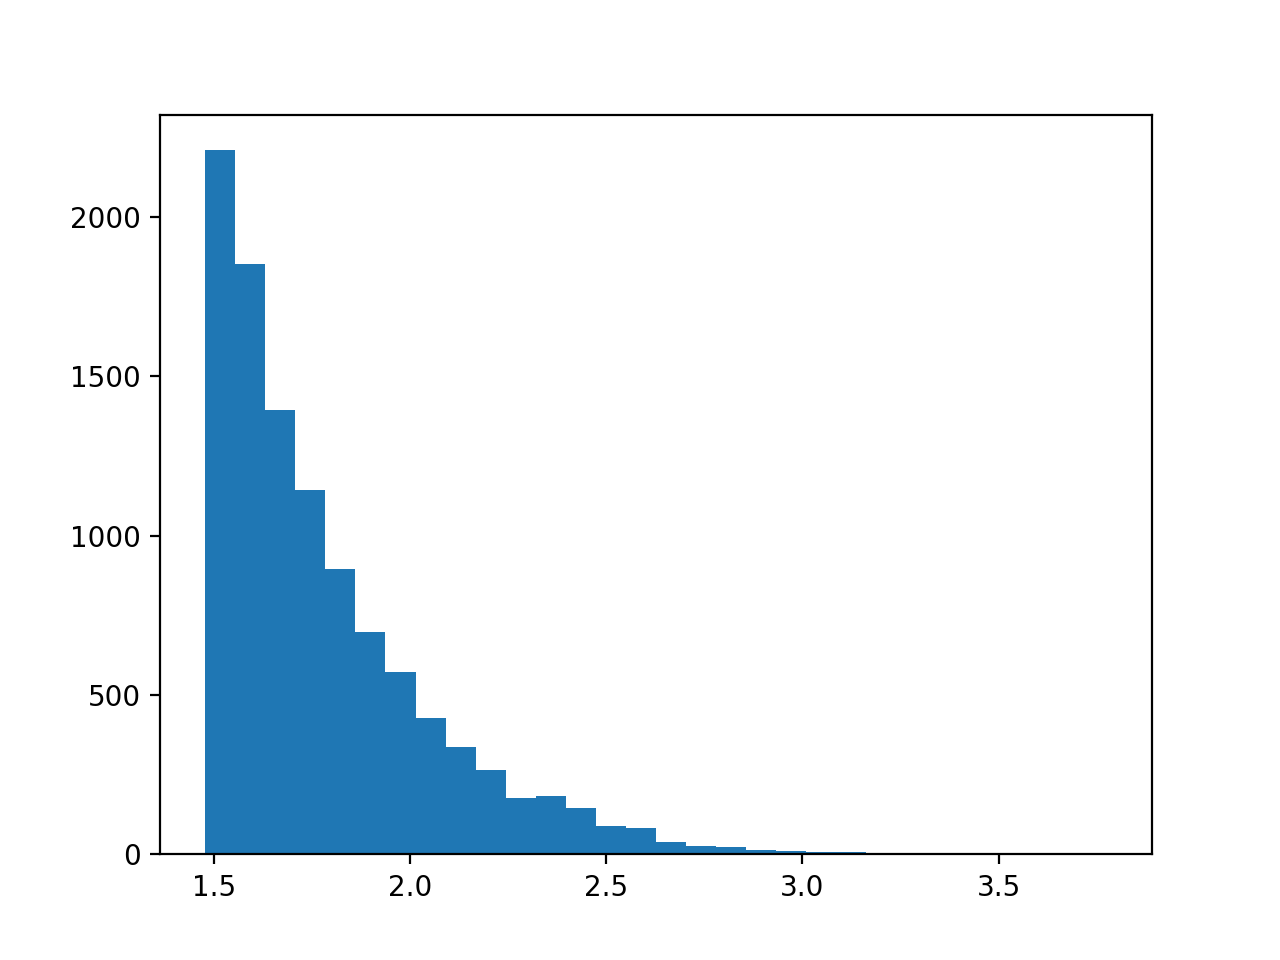

In [17]:
%matplotlib inline
_ = plt.hist(np.log10(imp_merged.totalCount), 30) # when/where did this get filtered?! only includes totalCount >= 10

In [18]:
het = imp_merged[np.logical_and(imp_merged.dosage > 0.93, imp_merged.dosage < 1.07)].copy()
het["phased_ratio"] = np.where(het.GT == "0|1", het.input_ratio, 1. - het.input_ratio)
het

contig  position_hg19   variantID refAllele altAllele   GT  dosage1  \
0      chr10         459940   rs4881274         G         A  0|1      0.0   
1      chr10        1034412  rs12772979         C         T  0|1      0.0   
2      chr10        1046712   rs2306409         G         A  1|0      1.0   
3      chr10        1090469  rs66797613         C         T  0|1      0.0   
4      chr10        3150898  rs11251721         C         T  1|0      1.0   
...      ...            ...         ...       ...       ...  ...      ...   
10616   chr9      139617662     rs11849         T         C  1|0      1.0   
10617   chr9      139618283      rs6873         A         G  1|0      1.0   
10618   chr9      139619366      rs6866         C         G  1|0      1.0   
10619   chr9      140084376  rs11556580         G         A  1|0      1.0   
10620   chr9      140084485   rs3087779         G         A  1|0      1.0   

       dosage2   position  refCount  altCount  totalCount  input_ratio  \
0         1.00     414000        20        18          38     0.473684   
1         0.95     988472        13        24          37     0.648649   
2         0.00    1000772        51        74         125     0.592000   
3         1.00    1044529        21        13          34     0.382353   
4         0.00    3108706        53        49         102     0.480392   
...        ...        ...       ...       ...         ...          ...   
10616     0.00  136723210        25        22          47     0.468085   
10617     0.00  136723831        34        31          65     0.476923   
10618     0.00  136724914        33        32          65     0.492308   
10619     0.05  137189924        41        48          89     0.539326   
10620     0.05  137190033        31        31          62     0.500000   

       dosage  phased_ratio  
0        1.00      0.473684  
1        0.95      0.648649  
2        1.00      0.408000  
3        1.00      0.382353  
4        1.00      0.519608  
...       ...           ...  
10616    1.00      0.531915  
10617    1.00      0.523077  
10618    1.00      0.507692  
10619    1.05      0.460674  
10620    1.05      0.500000  

[9815 rows x 15 columns]

In [19]:
from sklearn.neighbors import NearestNeighbors

dists = []
rats = []

for chrom in range(1,23):
    print(chrom, end = "\r")
    chrdat = het[het.contig == ("chr%i" % chrom)]
    chrdat = chrdat[chrdat.totalCount >= 30]
    X = chrdat.position.to_numpy().reshape(-1, 1)
    nbrs = NearestNeighbors(n_neighbors=5).fit(X)
    distances, indices = nbrs.radius_neighbors(X, radius = 2000)
    phased_ratio = chrdat.phased_ratio.to_numpy()
    ratios = np.concatenate([ (phased_ratio[i] - phased_ratio[j]) for i,j in enumerate(indices) ])
    dist = np.concatenate(distances)
    to_keep = dist > 0
    dists.append( dist[to_keep] )
    rats.append( ratios[to_keep] )


In [20]:
p = het.phased_ratio[het.totalCount >= 30]
s = p.std()
np.sqrt(2.) * s

0.10428365066805474

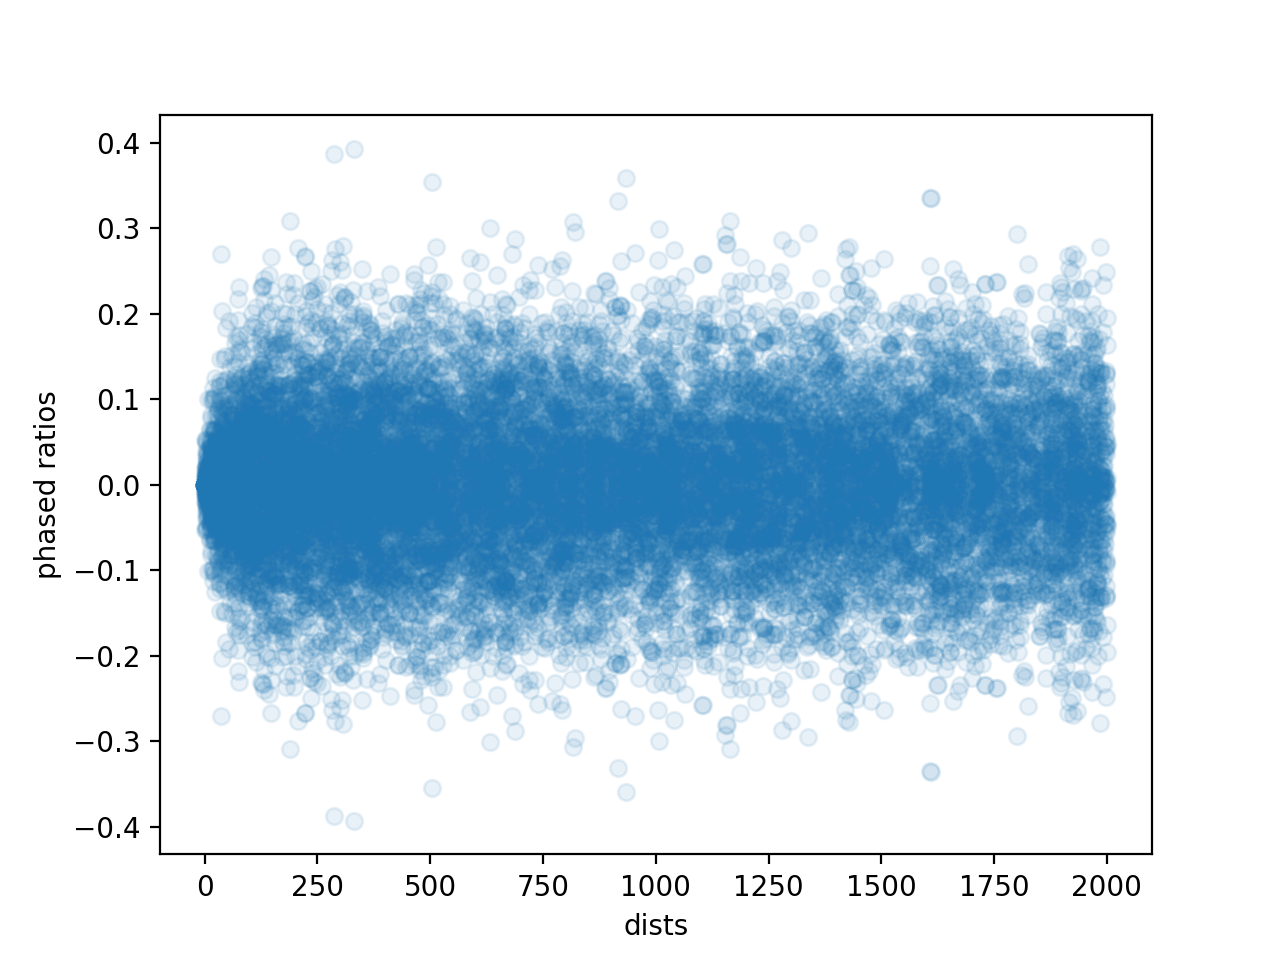

In [21]:
dist = np.concatenate(dists)
ratios = np.concatenate(rats)
plt.scatter(dist, ratios, alpha = 0.1)
plt.xlabel("dists")
plt.ylabel("phased ratios")
plt.show()

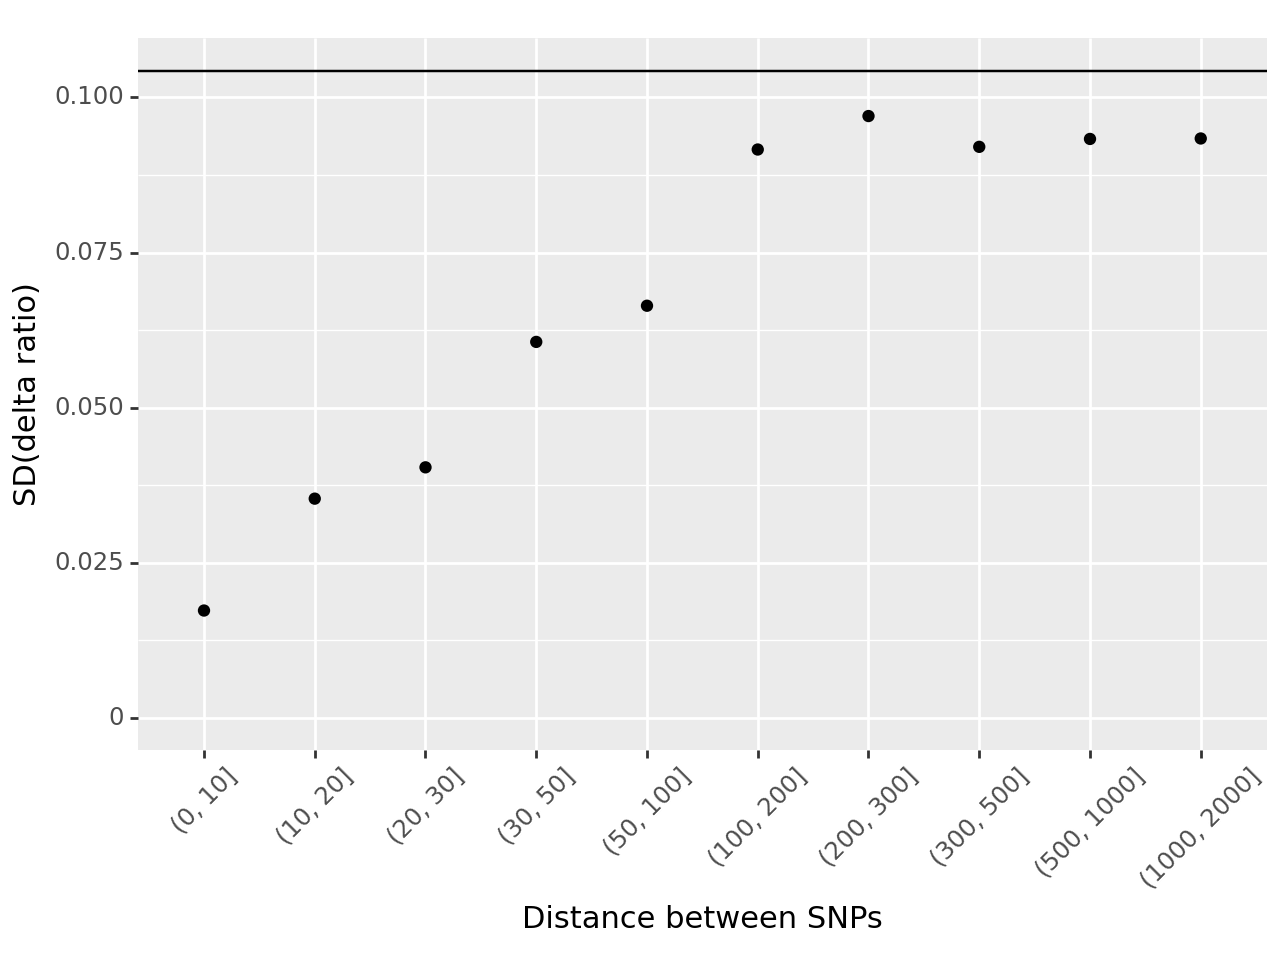

<Figure Size: (640 x 480)>

In [22]:
delta = pd.DataFrame({ "dist" : dist, "delta_ratio" : ratios})
delta["dist_discrete"] = pd.cut(
    delta.dist,
    bins=[0, 10, 20, 30, 50, 100, 200, 300, 500, 1000, 2000])

summed = delta.groupby('dist_discrete', as_index=False).agg({'delta_ratio' : 'std'})

( p9.ggplot(summed, p9.aes("dist_discrete", 'delta_ratio')) + 
 p9.geom_point() + 
 p9.theme(axis_text_x = p9.element_text(angle = 45)) + 
 p9.ylab("SD(delta ratio)") + 
 p9.xlab("Distance between SNPs") + 
 p9.geom_hline(yintercept = np.sqrt(2.) * s) +
 p9.expand_limits(y = [0])
)

In [23]:
from pooledQTL import interval_utils

exons = pd.read_csv("/home/dmeyer/projects/bqtls/hg38/gencode.v38.exons.txt.gz", 
                       sep = "\t",  
                       index_col = False, usecols = range(3)).rename(columns = {"chr" : "chrom"})
exons = exons[(exons.end - exons.start) >= 9] # remove super short exons

In [24]:
len(chroms)

3038869

In [25]:
sanger.shape

(34582504, 16)

In [85]:
#exons_tree = interval_utils.to_interval_trees(exons, chroms)
#overlap["exonic"] = interval_utils.get_overlap(exons_tree, overlap)

In [26]:
genes = pd.read_csv("/home/dmeyer/projects/bqtls/hg38/genes.tsv.gz", 
                       sep = "\t",  
                       index_col = False, usecols = range(3)).rename(columns = {"chr" : "chrom"})
genes = genes[genes.end - genes.start >= 100]

In [39]:
#genes_tree = interval_utils.to_interval_trees(genes, chroms)
#
#overlap["genic"] = interval_utils.get_overlap(genes_tree, overlap)

# Load IP count data and join with input and genotype

In [19]:
results_file

PosixPath('/gpfs/commons/home/dmeyer/bindingQTL_share/24a-hNIL-control-tdp/allelic/24a-hNIL-control-tdp_beta_filtered_epsilon0.3_ipreads30_allhet_struct.tsv.gz')

In [20]:
rbps

['24a-hNIL-control-tdp',
 '24a-hNIL-c9-tdp',
 '24a-hNIP-control-tdp',
 '24a-hNIP-c9-tdp']

In [9]:
for i in range(len(rbps)):
    dat = input_counts_filtered[i]
    dat_IP = IP_counts[i]
    sample_ind = donors[i]
    
    dat = dat.rename(columns={ "chrom":"contig" })
    dat = dat[dat.variantID != "."]
    dat = dat[~dat.variantID.duplicated()]
    dat_IP = dat_IP[dat_IP.variantID != "."]
    dat_IP = dat_IP[~dat_IP.variantID.duplicated()]
    
    imp_merged = sanger.merge(
        dat, 
        on = ["contig", "position", "variantID", "refAllele", "altAllele"]#, suffixes = ["_hg19",""]
    ) # sanger is GRCh38
    # there are only 0.08% flipped alleles so not worth doing.
    # np.isnan(imp_merged.iloc[:,5:16]).any() all False
    imp_merged["input_ratio"] = imp_merged.altCount / imp_merged.totalCount
    imp_merged = imp_merged[~imp_merged[sample_ind].isna()]
    imp_merged["pred_ratio"] = imp_merged.loc[:,sample_ind].to_numpy()
    merged = imp_merged.merge(
        dat_IP, 
        on = ("contig", "position", "variantID", "refAllele", "altAllele"), 
        suffixes = ("_input", "_IP"))
    #merged = merged.drop(labels=["contig_y", "position_x" ], axis=1)
    
    merged["IP_ratio"] = merged.altCount_IP / merged.totalCount_IP
    
    print(merged.shape)
    
    # filter for reasonable counts -- previous method
    #input_total_min = 10
    #allele_count_min = 4 
    #ip_total_min = 30
    #dat_sub = merged[merged.totalCount_input >= input_total_min]
    #dat_sub = dat_sub[dat_sub.refCount_input >= allele_count_min]
    #dat_sub = dat_sub[dat_sub.altCount_input >= allele_count_min]
    #dat_sub = dat_sub[dat_sub.totalCount_IP >= ip_total_min]
    #dat_sub = dat_sub[dat_sub.pred_ratio >= 0.45]
    #dat_sub = dat_sub[dat_sub.pred_ratio <= 0.55]
    
    ip_total_min = 30
    dat_sub = merged[merged.totalCount_IP >= ip_total_min]
    print(dat_sub.shape)
    
    epsilon = 0.3
    results_dir = PosixPath(f'/gpfs/commons/home/dmeyer/bindingQTL_share/{rbps[i]}/allelic')
    results_file = results_dir / (f"{rbps[i]}_beta_10readsInput_filtered_epsilon0.3_ipreads30_allhet_struct.tsv.gz")
    results = beta_model.fit_and_save(dat_sub, 
                                     results_file,
                                     use_structured_guide = True,
                                     iterations = 1000,
                                     device = device)

(3788, 16)
(3788, 16)
Learned hyperparameters: {'input_conc': 137.36587524414062, 'input_count_conc': 308.870361328125, 'IP_conc': 15.44893741607666, 'IP_count_conc': 24.963293075561523}
(3224, 16)
(3224, 16)
Learned hyperparameters: {'input_conc': 131.1009979248047, 'input_count_conc': 283.6369323730469, 'IP_conc': 13.264203071594238, 'IP_count_conc': 21.122467041015625}
(2860, 16)
(2860, 16)
Learned hyperparameters: {'input_conc': 122.82803344726562, 'input_count_conc': 270.4912414550781, 'IP_conc': 15.888285636901855, 'IP_count_conc': 27.219032287597656}
(3011, 16)
(3011, 16)
Learned hyperparameters: {'input_conc': 133.3123016357422, 'input_count_conc': 276.6358642578125, 'IP_conc': 11.971909523010254, 'IP_count_conc': 18.760974884033203}


# Run beta models

In [8]:
from pathlib import PosixPath
import plotnine as p9

In [15]:
#results = pd.read_csv(results_file, sep="\t")

In [ ]:
epsilon = 0.3
results_dir = PosixPath(f'/gpfs/commons/home/dmeyer/bindingQTL_share/{rbps[i]}/allelic')
results_file = results_dir / (f"{rbps[i]}_beta_10readsInput_filtered_epsilon0.3_ipreads30_allhet_struct.tsv.gz")
results = beta_model.fit_and_save(dat_sub, 
                                 results_file,
                                 use_structured_guide = True,
                                 iterations = 1000,
                                 device = device)

In [33]:
print("\n".join(rbps))

24a-hNIL-control-tdp
24a-hNIL-c9-tdp
24a-hNIP-control-tdp
24a-hNIP-c9-tdp


In [ ]:
this_rbp = rbps[3]
results_dir = PosixPath(f'/gpfs/commons/home/dmeyer/bindingQTL_share/{this_rbp}/allelic')
results_file = results_dir / (f"{this_rbp}_beta_filtered_epsilon0.3_ipreads30_allhet_struct.tsv.gz")
results = pd.read_csv(results_file, sep="\t")
print("\n".join(results.variantID[results.asb_q < .05]))

/tmp/ipykernel_20506/3282432280.py:14: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


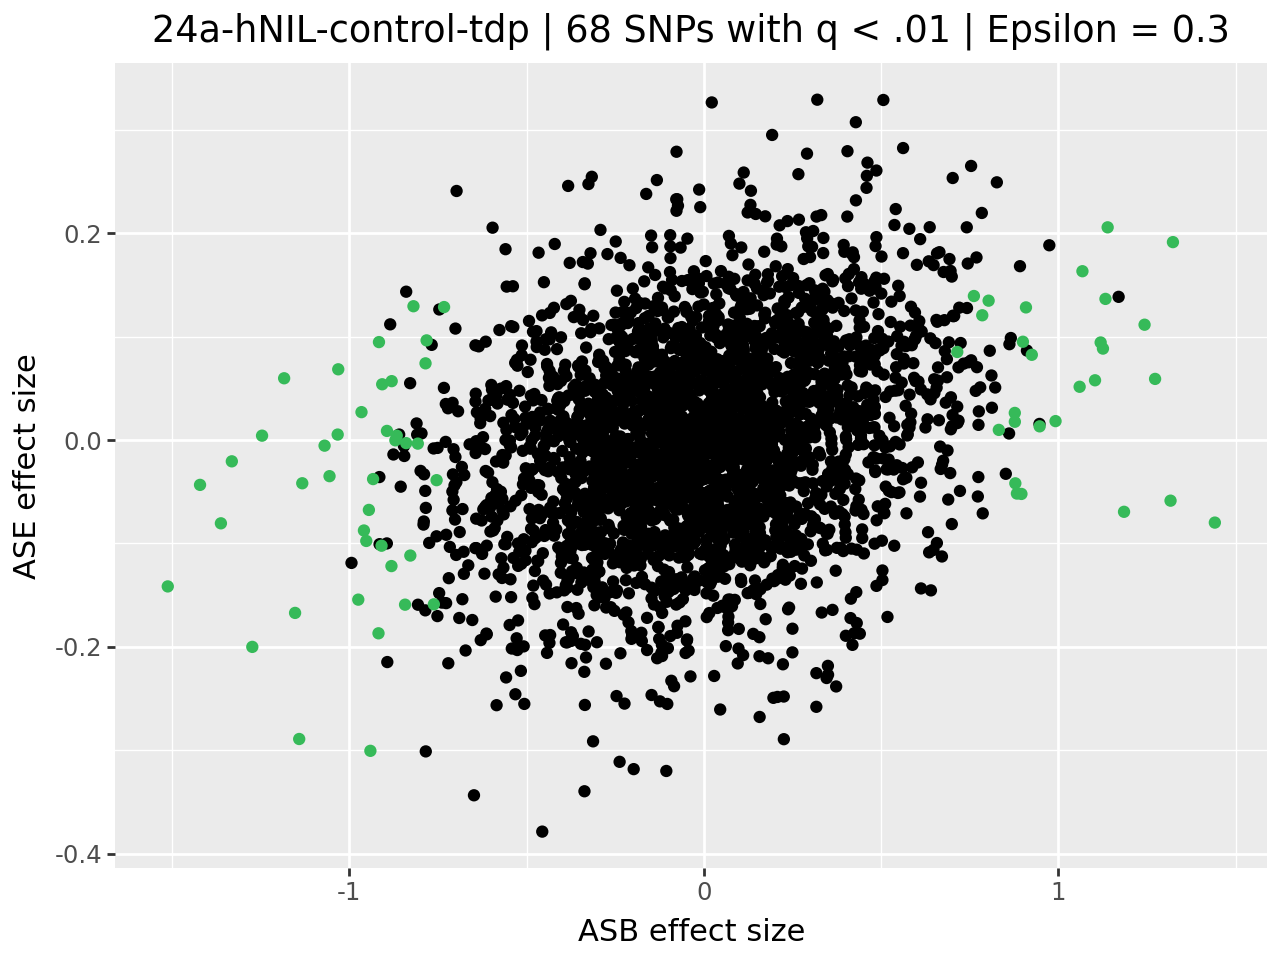

/tmp/ipykernel_20506/3282432280.py:14: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


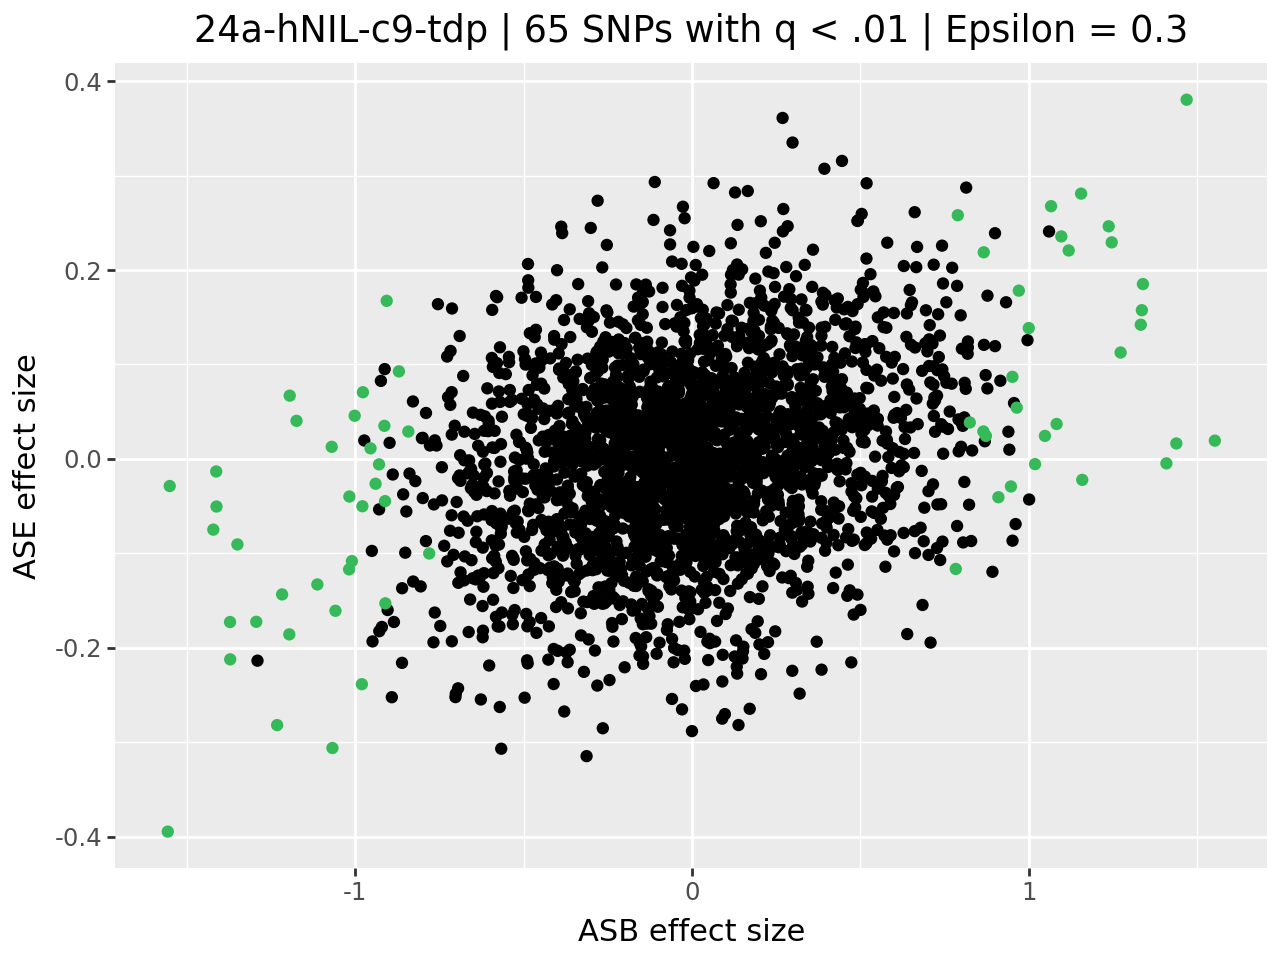

/tmp/ipykernel_20506/3282432280.py:14: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


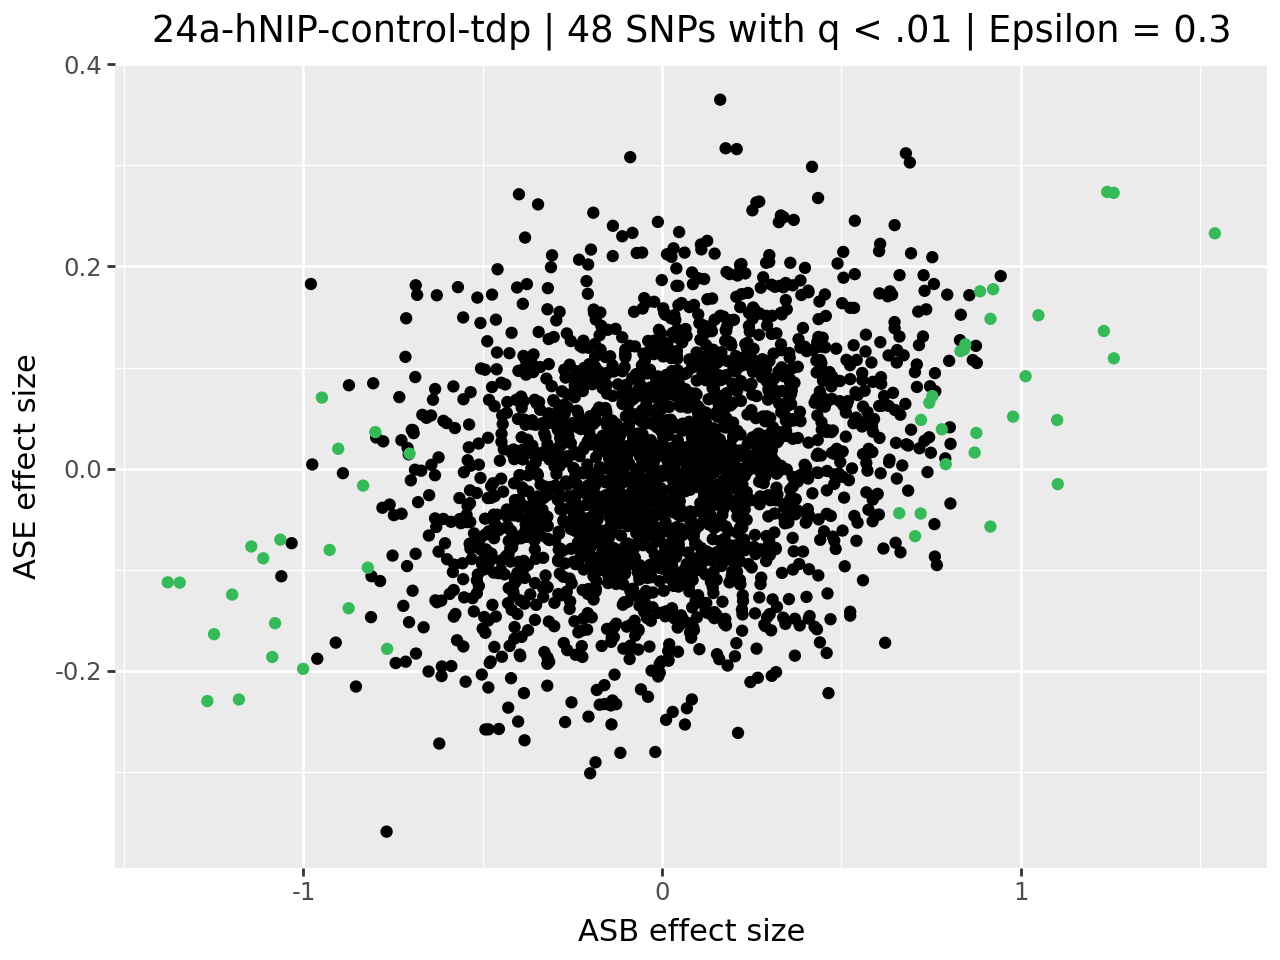

/tmp/ipykernel_20506/3282432280.py:14: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


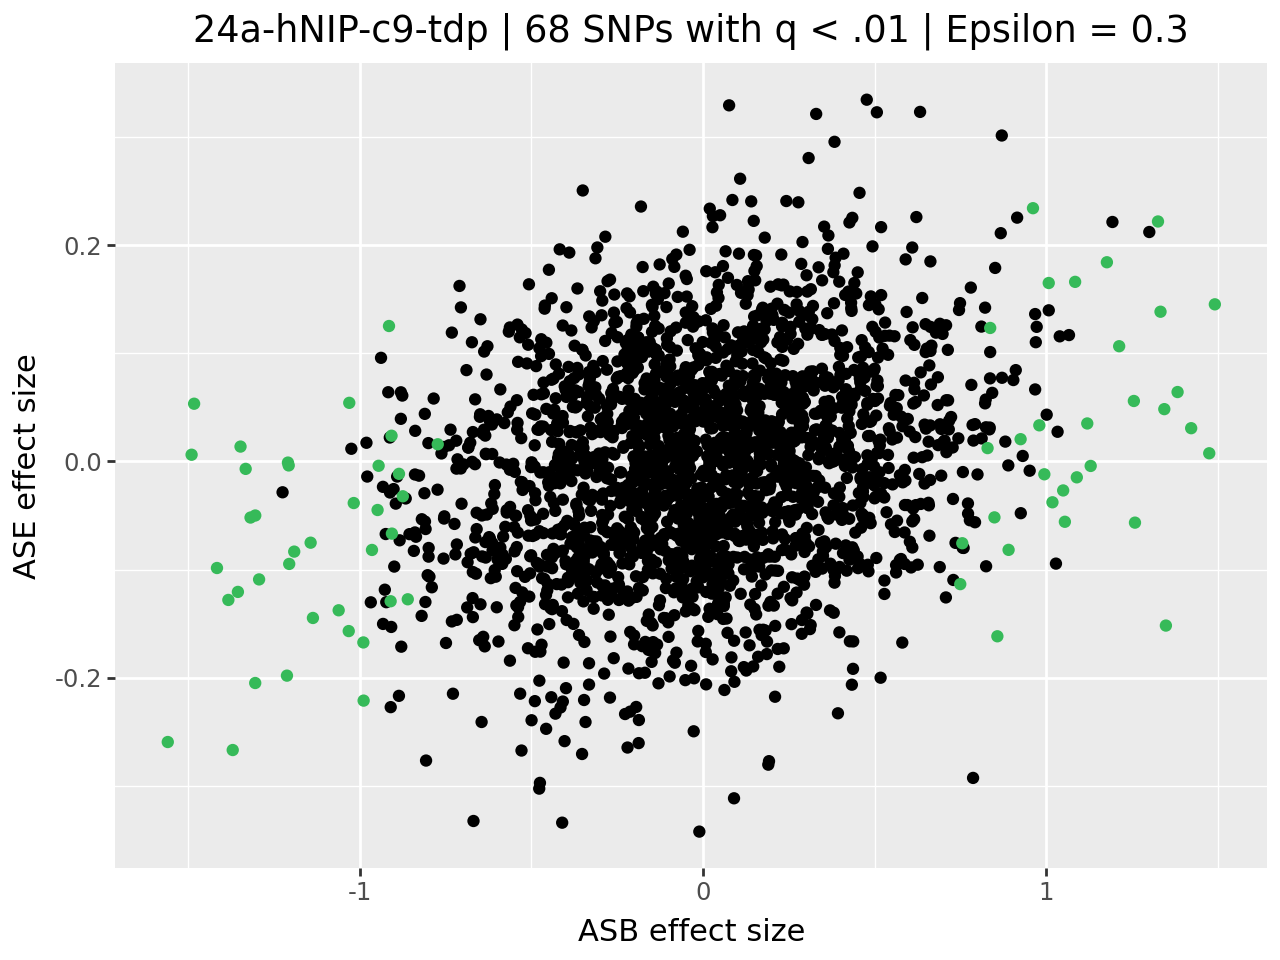

In [22]:
for i in range(len(rbps)):
    this_rbp = rbps[i]
    epsilon = 0.3
    qthresh = 0.01
    results_dir = PosixPath(f'/gpfs/commons/home/dmeyer/bindingQTL_share/{this_rbp}/allelic')
    results_file = results_dir / (f"{this_rbp}_beta_filtered_epsilon0.3_ipreads30_allhet_struct.tsv.gz")
    results = pd.read_csv(results_file, sep="\t")
    p = (p9.ggplot(results, p9.aes(x = "asb_loc", y = "ase_loc")) +
     p9.geom_point(data=results[results.asb_q >= qthresh])+
     p9.geom_point(data=results[results.asb_q < qthresh], color='#36ba59') +
     p9.labs(x = "ASB effect size", y = "ASE effect size", 
             title = f"{this_rbp} | {sum(results.asb_q < qthresh)} SNPs with q < .01 | Epsilon = {epsilon}")
    )
    print(p)

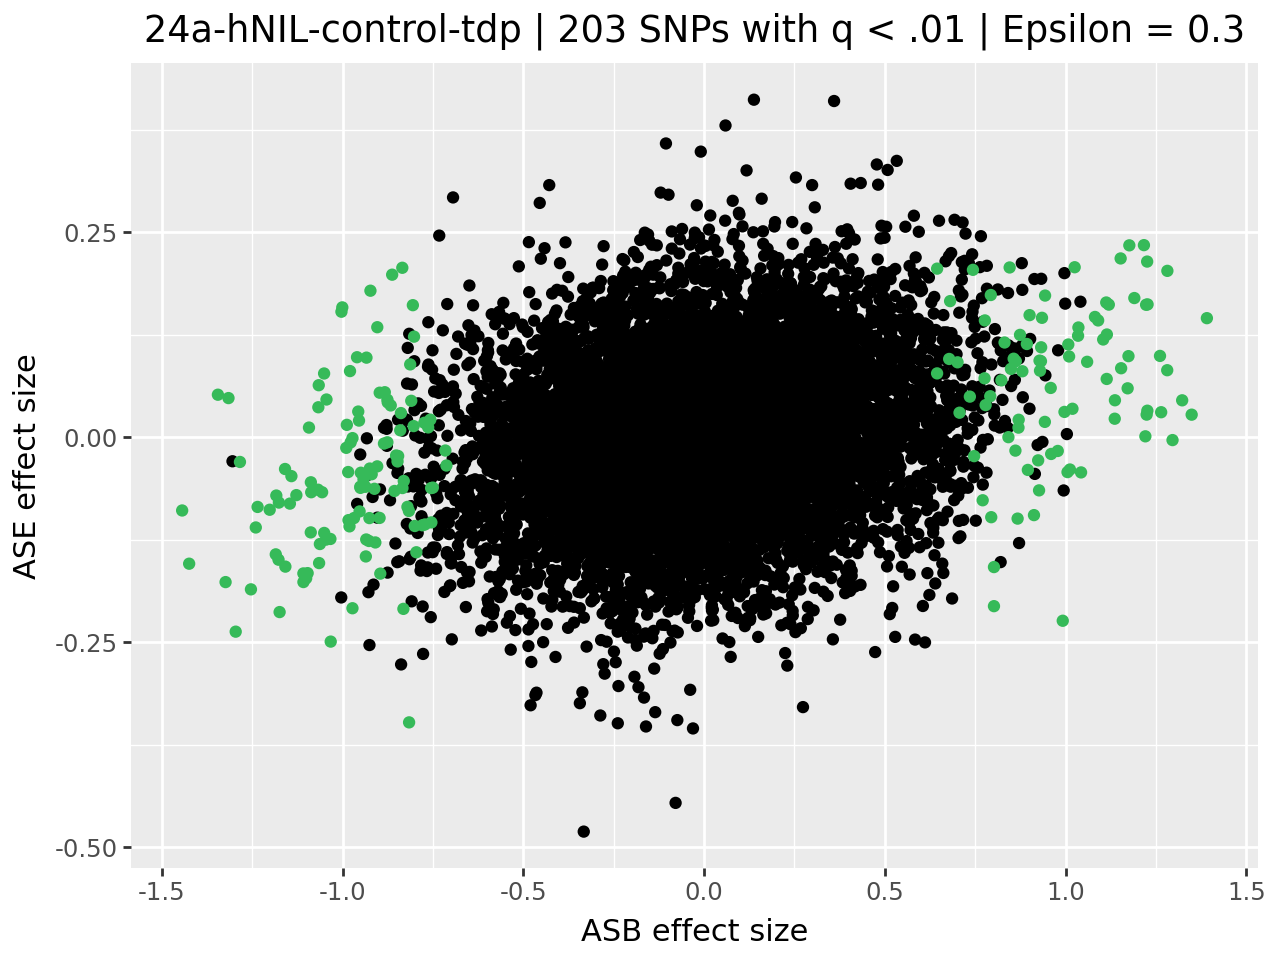

In [18]:
this_rbp = rbps[0]
epsilon = 0.3
qthresh = 0.01
results_dir = PosixPath(f'/gpfs/commons/home/dmeyer/bindingQTL_share/{this_rbp}/allelic')
results_file = results_dir / (f"{this_rbp}_beta_filtered_epsilon0.3_ipreads30_struct.tsv.gz")
results = pd.read_csv(results_file, sep="\t")
p = (p9.ggplot(results, p9.aes(x = "asb_loc", y = "ase_loc")) +
 p9.geom_point(data=results[results.asb_q >= qthresh])+
 p9.geom_point(data=results[results.asb_q < qthresh], color='#36ba59') +
 p9.labs(x = "ASB effect size", y = "ASE effect size", 
         title = f"{this_rbp} | {sum(results.asb_q < qthresh)} SNPs with q < .01 | Epsilon = {epsilon}")
)
p

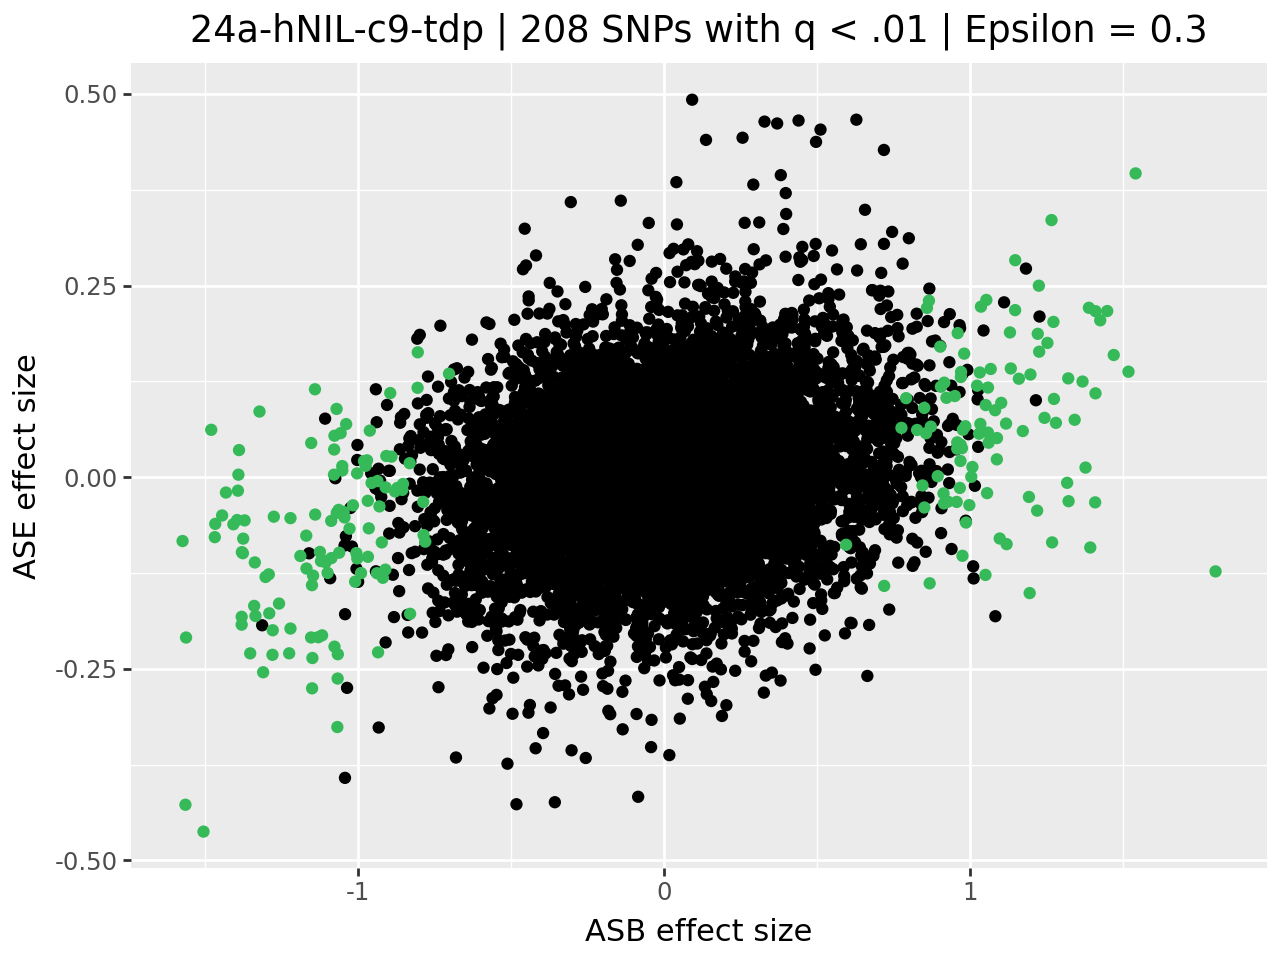

In [45]:
this_rbp = rbps[1]
epsilon = 0.3
qthresh = 0.01
results_dir = PosixPath(f'/gpfs/commons/home/dmeyer/bindingQTL_share/{this_rbp}/allelic')
results_file = results_dir / (f"{this_rbp}_beta_filtered_epsilon0.3_ipreads30_struct.tsv.gz")
results = pd.read_csv(results_file, sep="\t")
p = (p9.ggplot(results, p9.aes(x = "asb_loc", y = "ase_loc")) +
 p9.geom_point(data=results[results.asb_q >= qthresh])+
 p9.geom_point(data=results[results.asb_q < qthresh], color='#36ba59') +
 p9.labs(x = "ASB effect size", y = "ASE effect size", 
         title = f"{this_rbp} | {sum(results.asb_q < qthresh)} SNPs with q < .01 | Epsilon = {epsilon}")
)
p

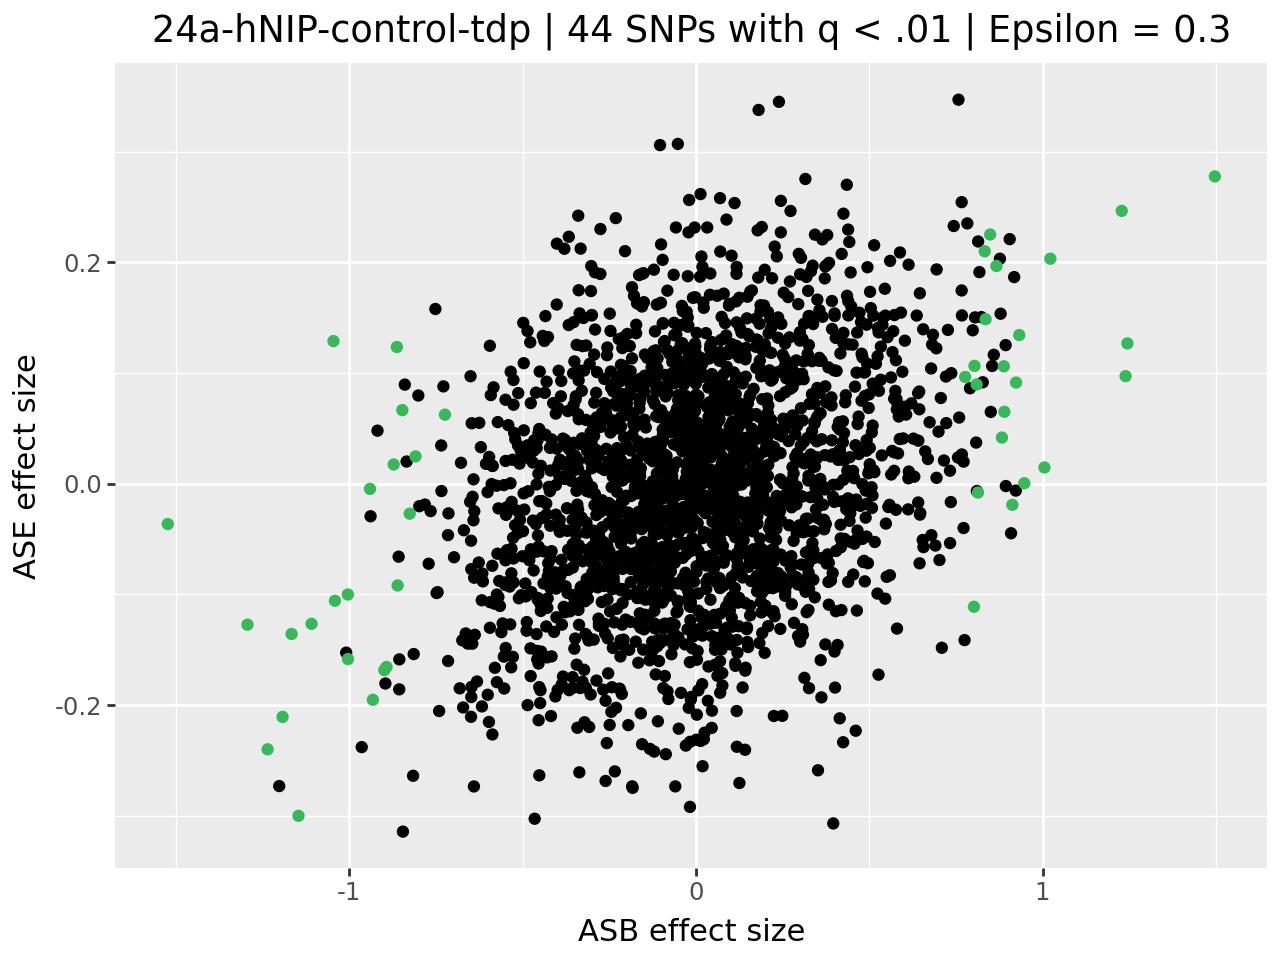

In [69]:
this_rbp = rbps[2]
epsilon = 0.3
qthresh = 0.01
results_dir = PosixPath(f'/gpfs/commons/home/dmeyer/bindingQTL_share/{this_rbp}/allelic')
results_file = results_dir / (f"{this_rbp}_beta_filtered_epsilon0.3_ipreads30_struct.tsv.gz")
results = pd.read_csv(results_file, sep="\t")
p = (p9.ggplot(results, p9.aes(x = "asb_loc", y = "ase_loc")) +
 p9.geom_point(data=results[results.asb_q >= qthresh])+
 p9.geom_point(data=results[results.asb_q < qthresh], color='#36ba59') +
 p9.labs(x = "ASB effect size", y = "ASE effect size", 
         title = f"{this_rbp} | {sum(results.asb_q < qthresh)} SNPs with q < .01 | Epsilon = {epsilon}")
)
p

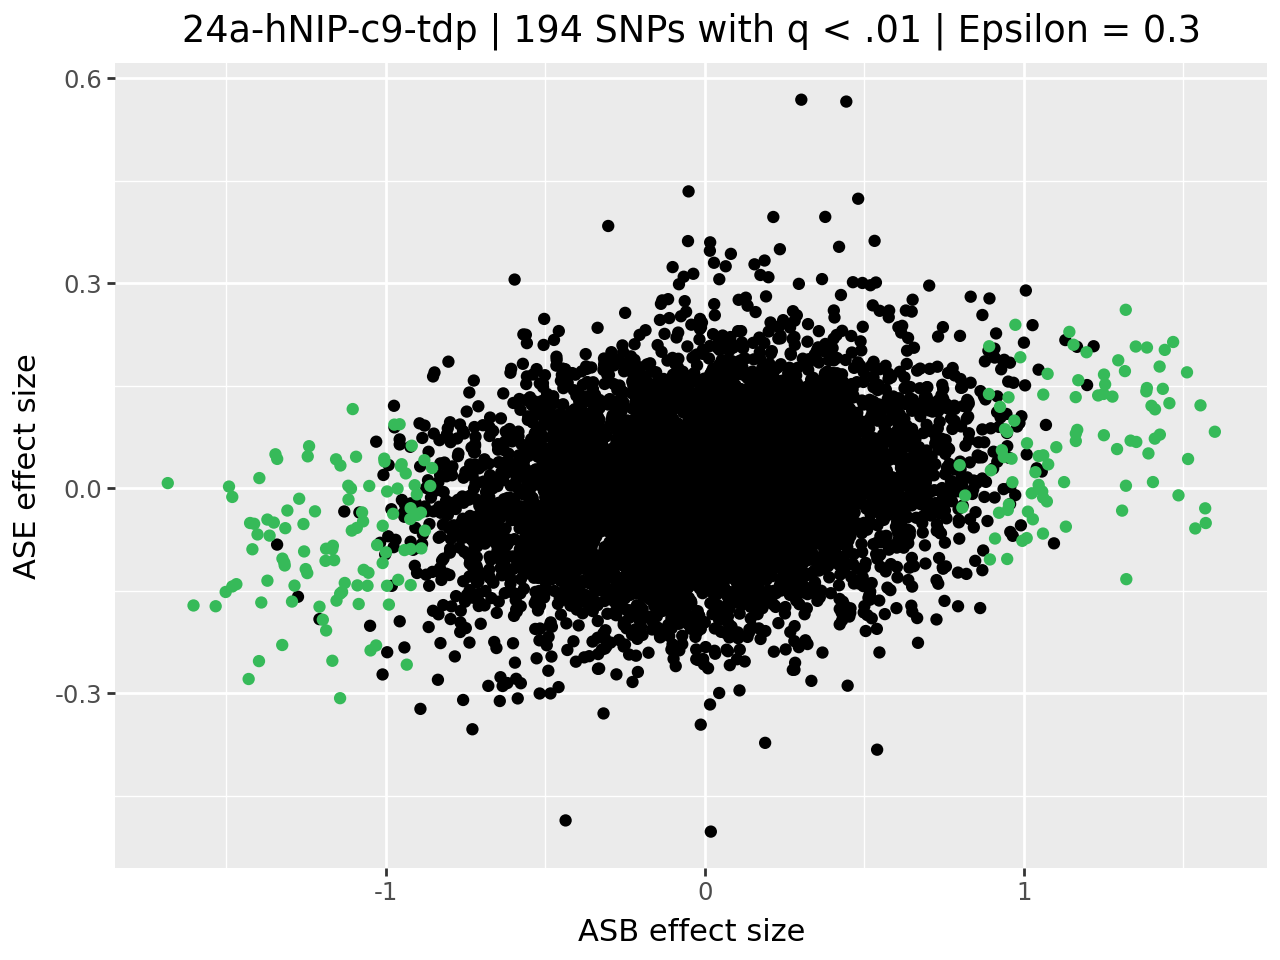

In [79]:
this_rbp = rbps[3]
epsilon = 0.3
qthresh = 0.01
results_dir = PosixPath(f'/gpfs/commons/home/dmeyer/bindingQTL_share/{this_rbp}/allelic')
results_file = results_dir / (f"{this_rbp}_beta_filtered_epsilon0.3_ipreads30_struct.tsv.gz")
results = pd.read_csv(results_file, sep="\t")
p = (p9.ggplot(results, p9.aes(x = "asb_loc", y = "ase_loc")) +
 p9.geom_point(data=results[results.asb_q >= qthresh])+
 p9.geom_point(data=results[results.asb_q < qthresh], color='#36ba59') +
 p9.labs(x = "ASB effect size", y = "ASE effect size", 
         title = f"{this_rbp} | {sum(results.asb_q < qthresh)} SNPs with q < .01 | Epsilon = {epsilon}")
)
p

In [ ]:
this_rbp = rbps[3]
qthresh = 0.05
results_dir = PosixPath(f'/gpfs/commons/home/dmeyer/bindingQTL_share/{this_rbp}/allelic')
results_file = results_dir / (f"{this_rbp}_beta_filtered_epsilon0.3_ipreads30_struct.tsv.gz")
results = pd.read_csv(results_file, sep="\t")
for x in results.variantID[results.asb_q < qthresh]:
    print(x)

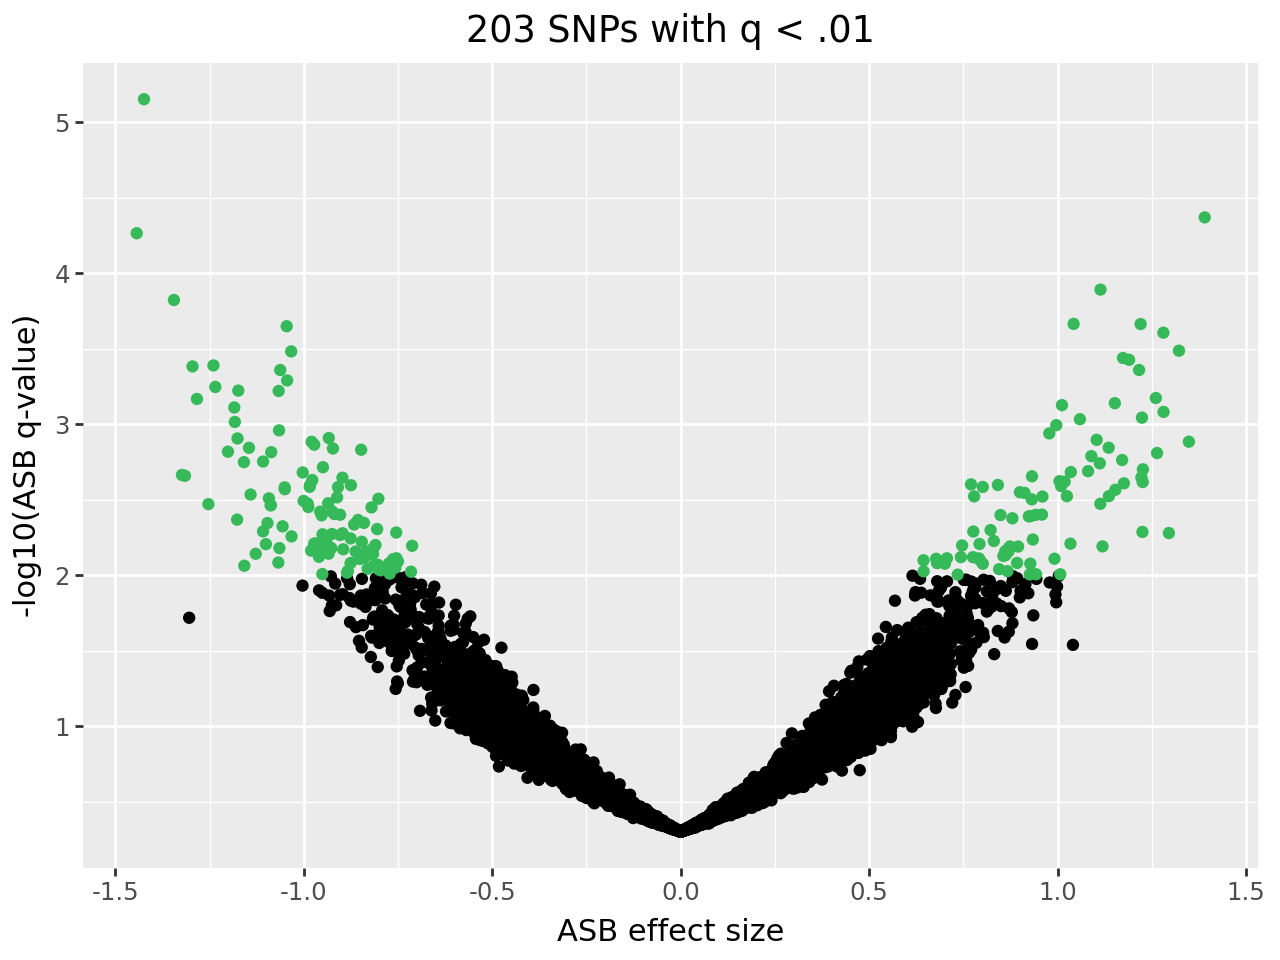

In [108]:
p = (p9.ggplot(results, p9.aes(x = "asb_loc", y = "-np.log10(asb_q)")) +
 p9.geom_point(data=results[results.asb_q >= 0.01])+
 p9.geom_point(data=results[results.asb_q < 0.01], color='#36ba59')+
    p9.labs(x = "ASB effect size", y = "-log10(ASB q-value)", title = f"{sum(results.asb_q < 0.01)} SNPs with q < .01")
)
p

In [19]:
results[(results.asb_q < .01) & (np.abs(results.asb_loc) > 1) & 
        (results.refCount_input > 4) &
        (results.altCount_input > 4) &
        (results.refCount_IP    > 4) &
        (results.altCount_IP    > 4)
       ][["variantID", "refAllele", "altAllele", "refCount_input", "altCount_input", "refCount_IP", "altCount_IP", "ase_loc", "ase_q", "asb_loc", "asb_q"]]

variantID refAllele altAllele  refCount_input  altCount_input  \
1000  rs115374873         T         C              27              27   
2657    rs1380813         G         A              59              52   
3681     rs870287         T         G              21              17   
5430    rs1185193         A         C              51              43   
5539   rs10796163         T         C              19              35   
6787    rs4772921         G         A              45              22   
6810     rs330566         G         A              26              21   
7184    rs3862138         C         T              33              27   
7410    rs3784634         C         T              30              45   
8248   rs12966029         G         A              19              38   

      refCount_IP  altCount_IP   ase_loc     ase_q   asb_loc     asb_q  
1000            5           36  0.034571  0.418410  1.018866  0.002398  
2657           72            8 -0.130395  0.153978 -1.062575  0.000437  
3681          205            8 -0.154392  0.114251 -1.424163  0.000007  
5430           34            5  0.045865  0.375783 -1.044331  0.000512  
5539           28            5  0.158229  0.128394 -1.000597  0.003219  
6787           61            5 -0.213390  0.051756 -1.173990  0.000598  
6810           64            7 -0.067219  0.303003 -1.086571  0.001529  
7184            6           46 -0.042664  0.389304  1.005207  0.002381  
7410           51            6  0.036422  0.402000 -1.066852  0.000601  
8248           42            5  0.152950  0.161539 -1.002966  0.002086

In [ ]:
results.in_peak

In [132]:
results[(results.asb_q < .01) & (np.abs(results.asb_loc) > 1) & 
        (results.in_peak == 1)
       ][["contig", "position", "variantID", "refAllele", "altAllele", "refCount_input", "altCount_input", "refCount_IP", "altCount_IP", "ase_loc", "ase_q", "asb_loc", "asb_q"]].rename(columns={"ase_loc": "ASE effect size", 
       "ase_q": "ASE q-value", "asb_loc": "ASB effect size", "asb_q": "ASB q-value"})

contig   position   variantID refAllele altAllele  refCount_input  \
618   chr12   46436069   rs4768121         A         G               8   
966   chr13   93233936   rs4594115         A         T              15   
1234  chr15   24974048   rs2554426         G         T             349   
1317  chr15   60434381   rs4774360         C         T               6   
2418   chr1   64082865  rs60795647         C         G               6   
2419   chr1   64082986   rs6668064         G         T               7   
2669   chr1  204100710   rs3795579         G         T              13   
4604   chr4   87926944  rs72657975         G         T             571   
4606   chr4   87927473  rs10002782         A         G             173   
4608   chr4   87931491  rs10005067         T         C             506   
4782   chr4  130045708   rs1022005         A         C               4   
5050   chr5  116473354    rs258017         C         T              24   

      altCount_input  refCount_IP  altCount_IP  ASE effect size   ASE q-value  \
618                7           36            0        -0.381037  6.161804e-02   
966                6            8           66        -0.076130  3.771250e-01   
1234               5          298            2        -1.906768  9.401624e-15   
1317               7           92            9        -0.206024  2.409710e-01   
2418               8            6           51         0.206043  2.256074e-01   
2419              11            4           44         0.293901  1.178405e-01   
2669              14           31            0        -0.250733  1.436236e-01   
4604               6          375            4        -2.089426  6.178014e-26   
4606              10          388            4        -1.410613  1.215197e-09   
4608               6          238            0        -2.076872  1.991957e-18   
4782               6           30            1        -0.178796  2.442273e-01   
5050              35          159           20         0.081145  3.506575e-01   

      ASB effect size  ASB q-value  
618         -1.405412     0.001967  
966          1.030768     0.006443  
1234        -1.446992     0.005151  
1317        -1.005312     0.006573  
2418         1.083594     0.005776  
2419         1.065249     0.007650  
2669        -1.242971     0.006672  
4604        -1.374112     0.004673  
4606        -1.546124     0.002907  
4608        -2.106251     0.008537  
4782        -1.191470     0.003657  
5050        -1.231360     0.000589

rs10005067 is a risk allele for "Total body bone mineral density (age 30-45)" falls in a large intergenic region
rs28028 is in an intronic region of SEMA6A gene; no clear GWAS signal or clinical significance
rs6684 in exonic region of NDUFAF4 gene; no clear GWAS signal or clinical significance
rs17126159 ROR1 : Intron Variant with no reported clinical significance

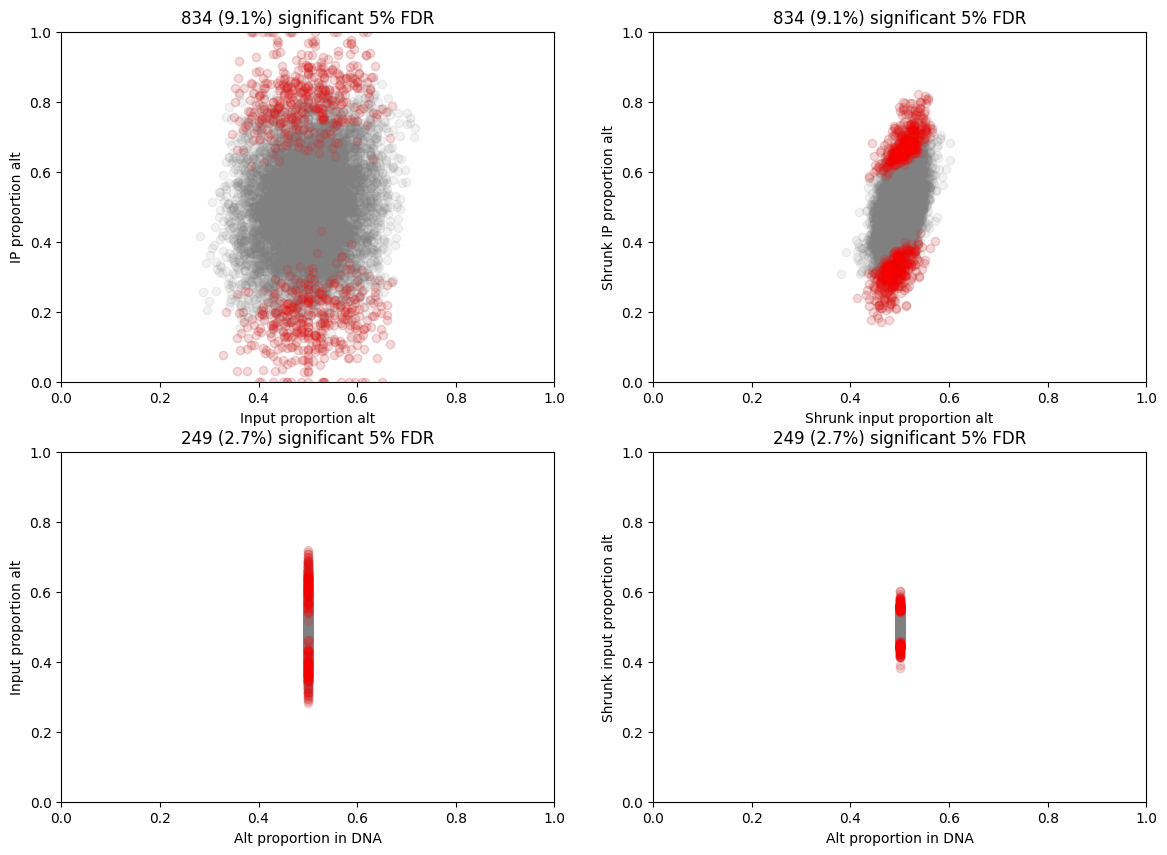

()

In [109]:
reload(beta_model)
beta_model.make_plots(results, fdr_threshold=0.05, sig_alpha=0.1)

For the beta model we model the two ratios (input and IP) separately but allow posterior dependence through the structured guide. For the Gaussian model we model the ASE effect (difference between DNA and RNA logit ratio) and ASB effect (difference between RNA and IP logit ratio). 

## Add in annotations

In [46]:
from pooledQTL import interval_utils

exons = pd.read_csv("/gpfs/commons/home/dmeyer/bindingQTL_share/gencode.v38.exons.txt.gz", 
                   sep = "\t",  
                   index_col = False, usecols = range(3)).rename(columns = {"chr" : "chrom"})
exons = exons[(exons.end - exons.start) >= 9] # remove super short exons

In [11]:
exons_tree = interval_utils.to_interval_trees(exons, exons.chrom.unique())

In [12]:
genc = pd.read_csv("/gpfs/commons/home/dmeyer/bindingQTL_share/gencode.v38.annotation.gtf.gz",
                   sep = "\t",  index_col = False, header=None, comment="#", usecols = range(5))
genc = genc.rename(columns={k:x for (k,x) in enumerate(["chrom", "gene", "annotation", "start", "end"])})

genc = genc[(genc.end - genc.start) >= 9] # remove super short annotations

In [14]:
def f(x):
    return interval_utils.to_interval_trees(x, genc.chrom.unique())
gene_tree = f(genc[genc.annotation == "gene"][genc.columns[[0,3,4]]])
transcript_tree = f(genc[genc.annotation == "transcript"][genc.columns[[0,3,4]]])
utr_tree = f(genc[genc.annotation == "UTR"][genc.columns[[0,3,4]]])

In [ ]:
input_files_filtered = [basedir / rbp / f"allelic/{rbp}_input_allelic.filtered_epsilon0.3.txt" for rbp in rbps]

In [50]:
def get_overlap_window(peaks, snps, window=100000): 
    return [min(len(peaks[row.chrom][row.position-window] | peaks[row.chrom][row.position] | peaks[row.chrom][row.position+window]), 1) for row in snps.itertuples() ]

In [53]:
for i in range(len(rbps)):
    rbp=rbps[i]
    results_dir = PosixPath(f'/gpfs/commons/home/dmeyer/bindingQTL_share/{rbp}/allelic')
    results_file = results_dir / (f"{rbp}_beta_10readsInput_filtered_epsilon0.3_ipreads30_allhet_struct.tsv.gz")
    results = pd.read_csv(results_file, sep="\t")
    
    peaks_file_pos = f"/gpfs/commons/home/dmeyer/bindingQTL_share/{rbp}/peaks/{rbp}-pos_peaks.narrowPeak"
    peaks_file_neg = f"/gpfs/commons/home/dmeyer/bindingQTL_share/{rbp}/peaks/{rbp}-neg_peaks.narrowPeak"
    peaks_pos = pd.read_csv(peaks_file_pos, 
                        header = None,
                        names= ["chrom", "start", "end", "name", "score", "strand", "signalValue", "pValue", "qValue", "peak"],
                        sep = "\t",  
                        index_col = False)
    peaks_neg = pd.read_csv(peaks_file_neg, 
                        header = None,
                        names= ["chrom", "start", "end", "name", "score", "strand", "signalValue", "pValue", "qValue", "peak"],
                        sep = "\t",  
                        index_col = False)
    peak_tree_pos = interval_utils.to_interval_trees(peaks_pos, peaks_pos.chrom.unique())
    peak_tree_neg = interval_utils.to_interval_trees(peaks_neg, peaks_neg.chrom.unique())
    res2 = results.rename(columns={"contig": "chrom"})

    results["in_peak_pos"] = interval_utils.get_overlap(peak_tree_pos, res2)
    results["in_peak_neg"] = interval_utils.get_overlap(peak_tree_neg, res2)
    results["in_peak"] = results["in_peak_neg"] | results["in_peak_neg"]
    results["near_peak_100k"] = np.array(get_overlap_window(peak_tree_pos, res2)) |  np.array(get_overlap_window(peak_tree_neg, res2))
    results["in_exon"] = interval_utils.get_overlap(exons_tree, results.rename(columns={"contig": "chrom"}))
    results["in_transcript"] = interval_utils.get_overlap(transcript_tree, results.rename(columns={"contig": "chrom"}))
    results["in_gene"] = interval_utils.get_overlap(gene_tree, results.rename(columns={"contig": "chrom"}))
    results["in_utr"] = interval_utils.get_overlap(utr_tree, results.rename(columns={"contig": "chrom"}))
    
    results_file_annotated = results_dir / (f"{rbps[i]}_beta_10readsInput_filtered_epsilon0.3_ipreads30_allhet_struct_with_peaks.tsv.gz")
    results.rename(columns={"contig": "chrom"}).to_csv(results_file_annotated, sep="\t", index=False)

In [21]:
x = results.rename(columns={"contig": "chrom"})
x = x.itertuples()

In [ ]:
row = x.__next__()

In [38]:
window = 100000
peak_tree_pos[row.chrom][row.position-window] | peak_tree_pos[row.chrom][row.position] | peak_tree_pos[row.chrom][row.position+window]

{Interval(7550073, 7554499)}

set()

In [ ]:
#?min
#return [ min(len(peaks[row.chrom][row.position]),1) for row in snps.itertuples() ]

In [51]:
for i in range(len(rbps)):
    rbp=rbps[i]
    results_dir = PosixPath(f'/gpfs/commons/home/dmeyer/bindingQTL_share/{rbp}/allelic')
    results_file = results_dir / (f"{rbp}_beta_filtered_epsilon0.3_ipreads30_allhet_struct.tsv.gz")
    results = pd.read_csv(results_file, sep="\t")
    
    peaks_file_pos = f"/gpfs/commons/home/dmeyer/bindingQTL_share/{rbp}/peaks/{rbp}-pos_peaks.narrowPeak"
    peaks_file_neg = f"/gpfs/commons/home/dmeyer/bindingQTL_share/{rbp}/peaks/{rbp}-neg_peaks.narrowPeak"
    peaks_pos = pd.read_csv(peaks_file_pos, 
                        header = None,
                        names= ["chrom", "start", "end", "name", "score", "strand", "signalValue", "pValue", "qValue", "peak"],
                        sep = "\t",  
                        index_col = False)
    peaks_neg = pd.read_csv(peaks_file_neg, 
                        header = None,
                        names= ["chrom", "start", "end", "name", "score", "strand", "signalValue", "pValue", "qValue", "peak"],
                        sep = "\t",  
                        index_col = False)
    peak_tree_pos = interval_utils.to_interval_trees(peaks_pos, peaks_pos.chrom.unique())
    peak_tree_neg = interval_utils.to_interval_trees(peaks_neg, peaks_neg.chrom.unique())

    results["in_peak_pos"] = interval_utils.get_overlap(peak_tree_pos, results.rename(columns={"contig": "chrom"}))
    results["in_peak_neg"] = interval_utils.get_overlap(peak_tree_neg, results.rename(columns={"contig": "chrom"}))
    results["in_peak"] = results["in_peak_neg"] | results["in_peak_neg"]
    results["in_exon"] = interval_utils.get_overlap(exons_tree, results.rename(columns={"contig": "chrom"}))
    results["in_transcript"] = interval_utils.get_overlap(transcript_tree, results.rename(columns={"contig": "chrom"}))
    results["in_gene"] = interval_utils.get_overlap(gene_tree, results.rename(columns={"contig": "chrom"}))
    results["in_utr"] = interval_utils.get_overlap(utr_tree, results.rename(columns={"contig": "chrom"}))
    
    results_file_annotated = results_dir / (f"{rbps[i]}_beta_filtered_epsilon0.3_ipreads30_allhet_struct_with_peaks.tsv.gz")
    results.rename(columns={"contig": "chrom"}).to_csv(results_file_annotated, sep="\t", index=False)

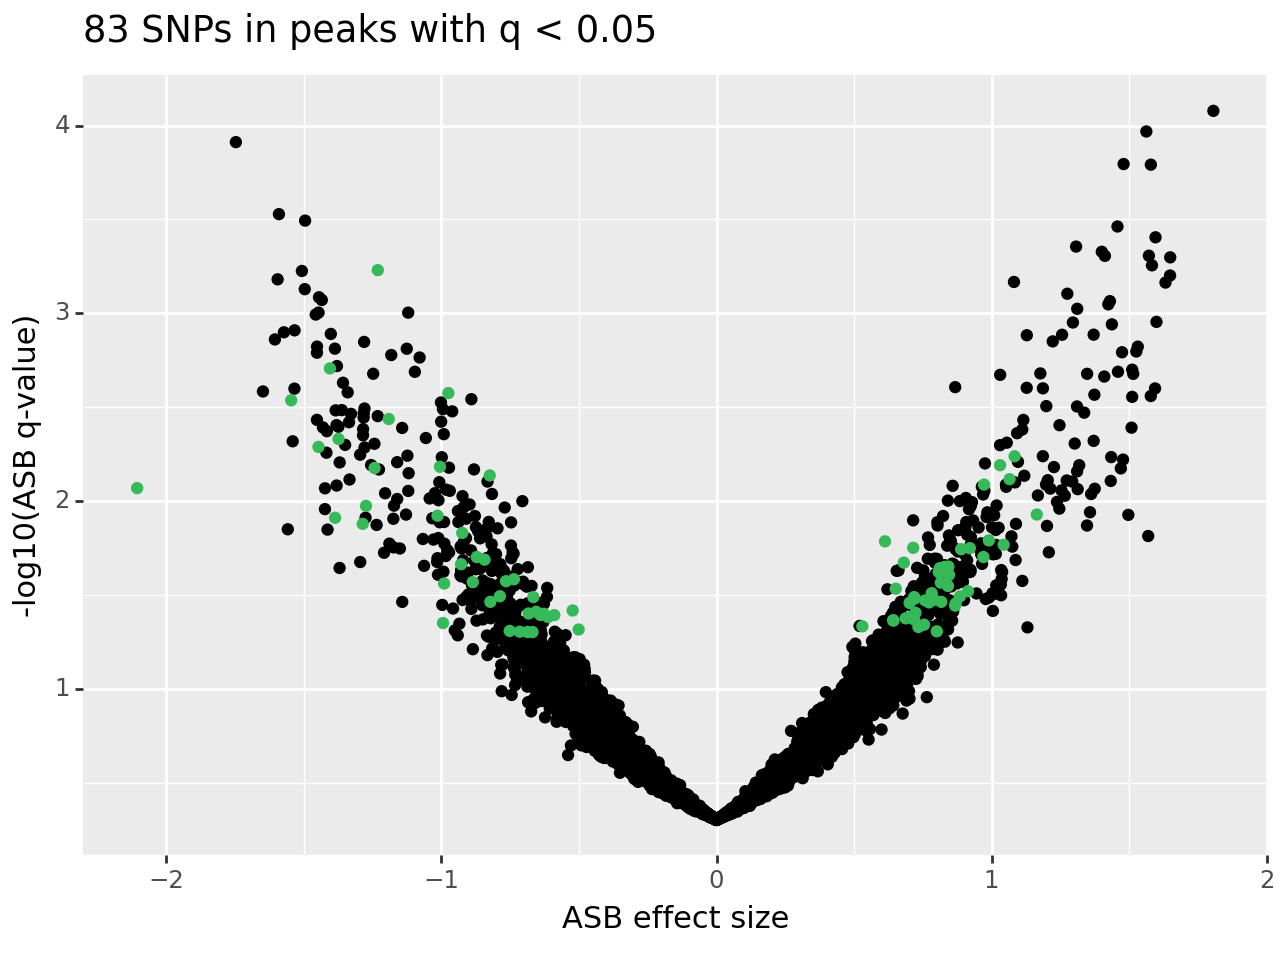

<Figure Size: (640 x 480)>

In [112]:
thresh=0.05
p = (p9.ggplot(results, p9.aes(x = "asb_loc", y = "-np.log10(asb_q)")) +
 p9.geom_point(data=results[(results.asb_q >= thresh)|(results.in_peak!=1)])+
 p9.geom_point(data=results[(results.asb_q < thresh)&(results.in_peak==1)], color='#36ba59')+
    p9.labs(x = "ASB effect size", y = "-log10(ASB q-value)", title = f"{sum((results.asb_q < thresh)&(results.in_peak==1))} SNPs in peaks with q < {thresh}")
)
p

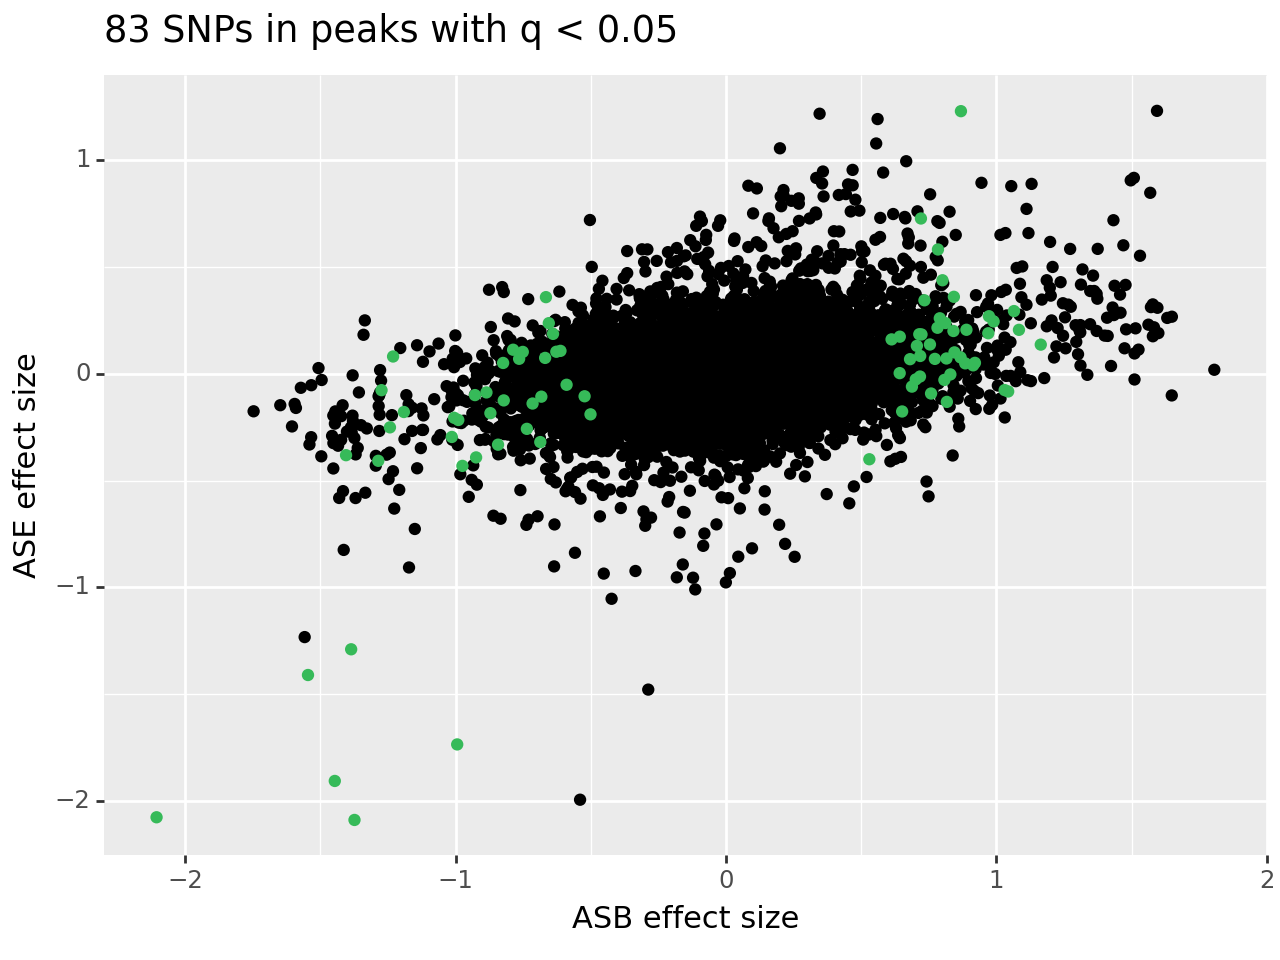

<Figure Size: (640 x 480)>

In [113]:
p = (p9.ggplot(results, p9.aes(x = "asb_loc", y = "ase_loc")) +
 p9.geom_point(data=results[(results.asb_q >= thresh)|(results.in_peak!=1)])+
 p9.geom_point(data=results[(results.asb_q < thresh)&(results.in_peak==1)], color='#36ba59')+
 p9.labs(x = "ASB effect size", y = "ASE effect size", title = f"{sum((results.asb_q < thresh)&(results.in_peak == 1))} SNPs in peaks with q < {thresh}")
)
p

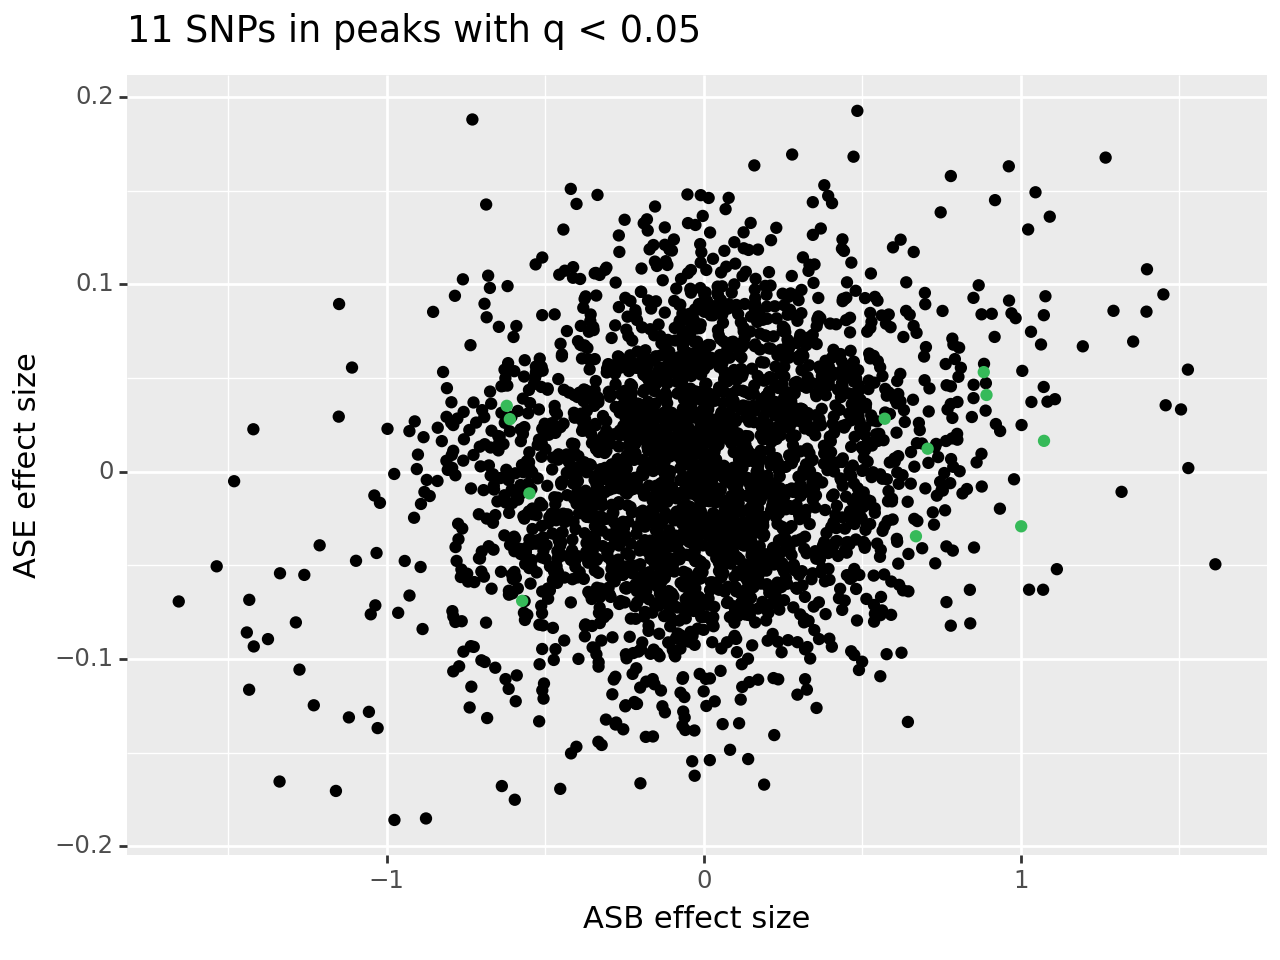

<Figure Size: (640 x 480)>

In [100]:
thresh=0.05
p = (p9.ggplot(results, p9.aes(x = "asb_loc", y = "ase_loc")) +
 p9.geom_point(data=results[(results.asb_q >= thresh)|(results.in_peak!=1)])+
 p9.geom_point(data=results[(results.asb_q < thresh)&(results.in_peak==1)], color='#36ba59')+
 p9.labs(x = "ASB effect size", y = "ASE effect size", title = f"{sum((results.asb_q < thresh)&(results.in_peak == 1))} SNPs in peaks with q < {thresh}")
)
p

In [102]:
print("\n".join(results.variantID[(results.asb_q < thresh)&(results.in_peak==1)]))

rs17801478
rs3203780
rs57094846
rs28773296
rs4539869
rs12715572
rs9862251
rs79563282
rs10473842
rs1052623
rs700082


In [134]:
results

contig  position_hg19   variantID refAllele altAllele   position  \
0     chr10        1040138   rs7070724         G         A     994198   
1     chr10        1046712   rs2306409         G         A    1000772   
2     chr10        1065191  rs17221491         A         G    1019251   
3     chr10        1675548  rs12267329         A         G    1633353   
4     chr10        1682481  rs10903520         G         A    1640286   
...     ...            ...         ...       ...       ...        ...   
6784   chr9      139318071      rs7628         A         G  136423619   
6785   chr9      139335599   rs1127152         A         G  136441147   
6786   chr9      139371786   rs6560632         A         C  136477334   
6787   chr9      139618283      rs6873         A         G  136723831   
6788   chr9      139619366      rs6866         C         G  136724914   

      refCount_input  altCount_input  totalCount_input  pred_ratio  ...  \
0                  8               8                16         0.5  ...   
1                 51              74               125         0.5  ...   
2                  4              10                14         0.5  ...   
3                  5               6                11         0.5  ...   
4                  6              10                16         0.5  ...   
...              ...             ...               ...         ...  ...   
6784              55              50               105         0.5  ...   
6785              37              19                56         0.5  ...   
6786              43              24                67         0.5  ...   
6787              34              31                65         0.5  ...   
6788              33              32                65         0.5  ...   

      shrunk_input_logratio   ase_loc    ase_sd     ase_q  shrunk_IP_logratio  \
0                  0.009045  0.009045  0.242887  0.485147           -0.181023   
1                  0.136659  0.136659  0.200529  0.247780           -0.435006   
2                  0.145541  0.145541  0.320083  0.324664            0.228376   
3                  0.171201  0.171201  0.249057  0.245916            0.689264   
4                 -0.036610 -0.036610  0.232647  0.437479           -0.279682   
...                     ...       ...       ...       ...                 ...   
6784              -0.180091 -0.180091  0.226761  0.213543           -0.209754   
6785              -0.331026 -0.331026  0.213242  0.060290           -0.584175   
6786              -0.328250 -0.328250  0.206881  0.056295           -0.575466   
6787              -0.084877 -0.084877  0.211950  0.344411           -0.901133   
6788              -0.159886 -0.159886  0.195265  0.206447           -0.540989   

       asb_loc    asb_sd     asb_q  in_peak  in_exon  
0    -0.190068  0.457175  0.338798        0        0  
1    -0.571664  0.424223  0.088901        0        1  
2     0.082835  0.447758  0.426614        0        1  
3     0.518062  0.441253  0.120183        1        0  
4    -0.243072  0.439876  0.290272        1        0  
...        ...       ...       ...      ...      ...  
6784 -0.029663  0.444518  0.473398        0        1  
6785 -0.253149  0.471046  0.295489        0        1  
6786 -0.247216  0.392782  0.264545        0        1  
6787 -0.816257  0.346087  0.009174        0        1  
6788 -0.381103  0.447421  0.197169        0        1  

[6789 rows x 23 columns]

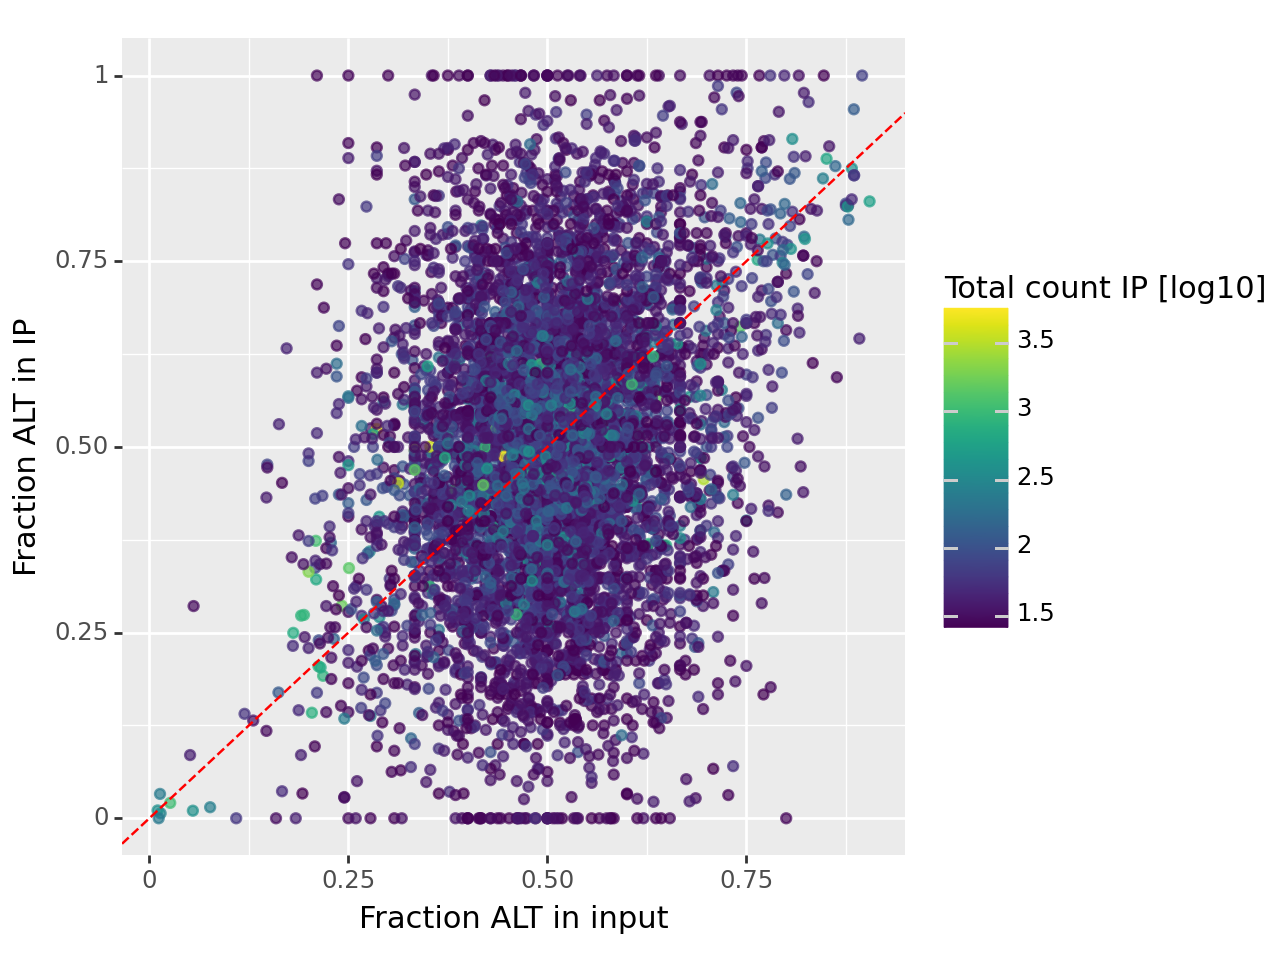

<Figure Size: (640 x 480)>

In [154]:
p = (p9.ggplot(results, p9.aes(x = "altCount_input/totalCount_input", y = "altCount_IP/totalCount_IP", color="np.log10(totalCount_IP)")) +
 p9.geom_point(data=results, alpha=0.7)+
# p9.geom_point(data=results[results.asb_q < 0.01], color='#36ba59')+
     p9.geom_abline(slope = 1, intercept = 0, color="red", linetype="dashed")+
     p9.labs(x = "Fraction ALT in input", y="Fraction ALT in IP", color="Total count IP [log10]")
 #p9.labs(x = "ASB effect size", y = "ASE effect size", title = f"{sum(results.asb_q < 0.01)} SNPs with q < .01")
)
p

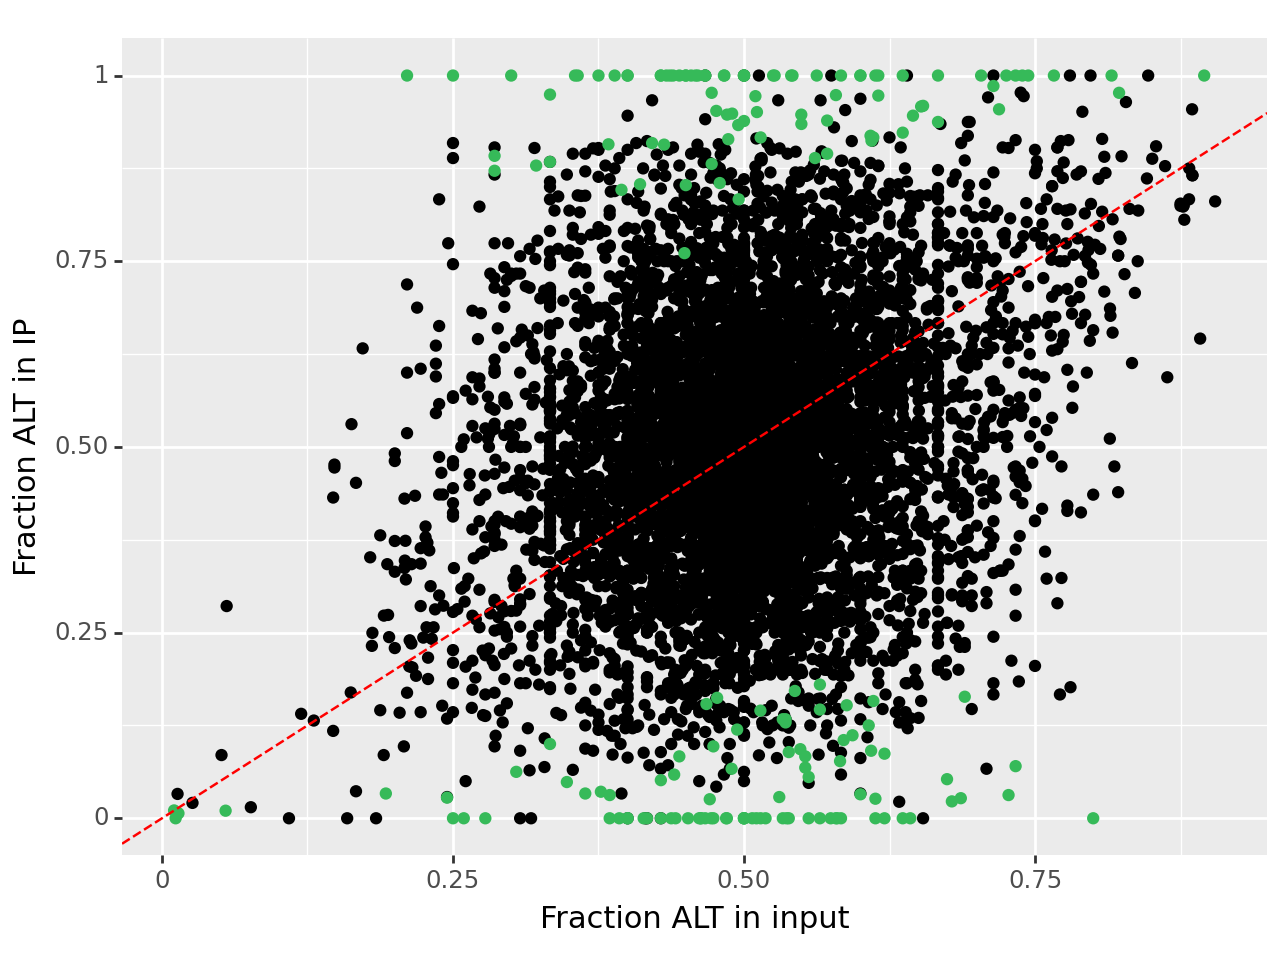

<Figure Size: (640 x 480)>

In [151]:
p = (p9.ggplot(results, p9.aes(x = "altCount_input/totalCount_input", y = "altCount_IP/totalCount_IP")) +
     p9.geom_point(data=results[results.asb_q >= 0.01])+
     p9.geom_point(data=results[results.asb_q < 0.01], color='#36ba59')+
     p9.geom_abline(slope = 1, intercept = 0, color="red", linetype="dashed")+
     p9.labs(x = "Fraction ALT in input", y="Fraction ALT in IP")
 #p9.labs(x = "ASB effect size", y = "ASE effect size", title = f"{sum(results.asb_q < 0.01)} SNPs with q < .01")
)
p

In [161]:
phased[phased.SNP == "rs12608932"]#[sample_ind]

contig  position         SNP refAllele altAllele   GT  dosage1  \
1050807  chr19  17752689  rs12608932         A         C  1|0     0.65   

         dosage2  
1050807     0.25

In [164]:
results[results.variantID == "rs12973192"]

Empty DataFrame
Columns: [contig, position_hg19, variantID, refAllele, altAllele, position, refCount_input, altCount_input, totalCount_input, pred_ratio, refCount_IP, altCount_IP, totalCount_IP, shrunk_input_logratio, ase_loc, ase_sd, ase_q, shrunk_IP_logratio, asb_loc, asb_sd, asb_q, in_peak, in_exon]
Index: []

[0 rows x 23 columns]

In [169]:
dat[dat.variantID == "rs12608932"]

Empty DataFrame
Columns: [contig, position, variantID, refAllele, altAllele, refCount, altCount, totalCount]
Index: []

In [170]:
dat[dat.variantID == "rs12973192"]

Empty DataFrame
Columns: [contig, position, variantID, refAllele, altAllele, refCount, altCount, totalCount]
Index: []

In [171]:
dat_IP[dat_IP.variantID == "rs12608932"]

contig  position   variantID refAllele altAllele  refCount  altCount  \
1481561  chr19  17641880  rs12608932         A         C       816         2   

         totalCount  
1481561         818

In [172]:
dat_IP[dat_IP.variantID == "rs12973192"]

contig  position   variantID refAllele altAllele  refCount  altCount  \
1481566  chr19  17642430  rs12973192         C         G       651         0   

         totalCount  
1481566         651

## 2024-01-26 request from David

How about we look at input SNPs and try to filter

```
mostly for Dan: Megan and i met yesterday. one idea we discussed is trying to filter for SNPs that we are confident show balance in the input, rather than trying to account for ASE in the ASB model. the question is how many SNPs we’d even get to test, especially in intronic regions where the input counts are low.
so, i think a good thing for you to try would be get a binomial confidence interval for the allelic proportion for each input SNP
i think you can do this with binomial.test
(actually i think the simulation code probably does that?)
we’d want that CI to be contained in [p-epsilon, p+epsilon] where p is the expected proportion (i.e. 0.5 in the single individual setting, whatever comes out of the deconvolution regression for the pooled setting)
you could vary epsilon in some range (maybe something like 0.1 would be a good starting point?) and see how many intronic and exonic SNP we would be able to test
probably easiest with a single individual first: i’m not sure quite how we should handle the situation where p is close to 0 or 1
```

In [241]:
x =  input_counts[0]

x["in_peak"] = interval_utils.get_overlap(peak_tree, x.rename(columns={"contig": "chrom"}))
x["in_exon"] = interval_utils.get_overlap(exons_tree, x.rename(columns={"contig": "chrom"}))
x["in_transcript"] = interval_utils.get_overlap(transcript_tree, x.rename(columns={"contig": "chrom"}))
x["in_gene"] = interval_utils.get_overlap(gene_tree, x.rename(columns={"contig": "chrom"}))
x["in_utr"] = interval_utils.get_overlap(utr_tree, x.rename(columns={"contig": "chrom"}))
x.to_csv("/home/dmeyer/projects/bqtls/tdp43/allelic/tdp43_input_annotated_allelic.out", index_label=False, sep="\t", index=False)

In [242]:
x = IP_counts[0]
x["in_peak"] = interval_utils.get_overlap(peak_tree, x.rename(columns={"contig": "chrom"}))
x["in_exon"] = interval_utils.get_overlap(exons_tree, x.rename(columns={"contig": "chrom"}))
x["in_transcript"] = interval_utils.get_overlap(transcript_tree, x.rename(columns={"contig": "chrom"}))
x["in_gene"] = interval_utils.get_overlap(gene_tree, x.rename(columns={"contig": "chrom"}))
x["in_utr"] = interval_utils.get_overlap(utr_tree, x.rename(columns={"contig": "chrom"}))
x.to_csv("/home/dmeyer/projects/bqtls/tdp43/allelic/tdp43_ip_annotated_allelic.out", index_label=False, sep="\t", index=False)

In [243]:
x

contig   position    variantID refAllele altAllele  refCount  \
0         chr1     128747  rs565117739         A         C        11   
1         chr1     137978  rs529853750         G         A       124   
2         chr1     139029  rs531551691         C         T        45   
3         chr1     139030  rs751110858         G         A        45   
4         chr1     139060  rs568513188         G         A        37   
...        ...        ...          ...       ...       ...       ...   
1620755  chr22   50785210  rs138253809         C         T        22   
1620756  chr22   50788205            .         A         T        11   
1620757  chr22   50798982            .         G         A        26   
1620758  chr22   50799058            .         G         C        31   
1620759   chrX  154768713  rs192006955         C         T        12   

         altCount  totalCount  in_peak  in_exon  in_transcript  in_gene  \
0               1          12        0        0              1        1   
1               0         124        0        0              0        0   
2               0          45        0        0              0        0   
3               0          45        0        0              0        0   
4               0          37        0        0              0        0   
...           ...         ...      ...      ...            ...      ...   
1620755         0          22        0        1              1        1   
1620756         0          11        0        0              1        1   
1620757         0          26        0        1              1        1   
1620758         0          31        0        1              1        1   
1620759         0          12        0        1              1        1   

         in_utr  
0             0  
1             0  
2             0  
3             0  
4             0  
...         ...  
1620755       0  
1620756       0  
1620757       0  
1620758       0  
1620759       0  

[1620760 rows x 13 columns]

In [92]:
dat_sub.shape

(6731, 16)

In [99]:
input_counts_filtered[3].shape

(13536, 8)

In [107]:
for i in range(len(rbps)):
    this_rbp = rbps[i]
    results_dir = PosixPath(f'/gpfs/commons/home/dmeyer/bindingQTL_share/{this_rbp}/allelic')
    results_file = results_dir / (f"{this_rbp}_beta_filtered_epsilon0.3_ipreads30_struct.tsv.gz")
    results = pd.read_csv(results_file, sep="\t")
    print(this_rbp, '\t', results.shape[0], 'variants tested')

24a-hNIL-control-tdp 	 9207 variants tested
24a-hNIL-c9-tdp 	 7733 variants tested
24a-hNIP-control-tdp 	 2259 variants tested
24a-hNIP-c9-tdp 	 6731 variants tested


In [ ]:
(9207, 22)
(7733, 22)
(2259, 22)
(6731, 22)

In [43]:
print('","'.join(map(str,input_files_filtered)))

/gpfs/commons/home/dmeyer/bindingQTL_share/24a-hNIL-control-tdp/allelic/24a-hNIL-control-tdp_input_allelic.filtered_epsilon0.3_sharedhet.txt","/gpfs/commons/home/dmeyer/bindingQTL_share/24a-hNIL-c9-tdp/allelic/24a-hNIL-c9-tdp_input_allelic.filtered_epsilon0.3_sharedhet.txt","/gpfs/commons/home/dmeyer/bindingQTL_share/24a-hNIP-control-tdp/allelic/24a-hNIP-control-tdp_input_allelic.filtered_epsilon0.3_sharedhet.txt","/gpfs/commons/home/dmeyer/bindingQTL_share/24a-hNIP-c9-tdp/allelic/24a-hNIP-c9-tdp_input_allelic.filtered_epsilon0.3_sharedhet.txt
